## CSC-696-001.2025F Final Project(3/3)
**Name: Anna Hyunjung Kim**

**Collaborators: Prof. Patrick Wu**





---





**Title:** Measuring Ethical Risks in AI-Generated News Using NLP with the UNESCO Ethics of AI Framework

**Research Question:** How many problematic errors occur ethically in news articles generated by AI to some extent. Also, which category of the AI ethics principles proposed by UNESCO do these issues correspond closest to?

**Purpose: I hope people won’t get lost in the growing maze of the AI world, and I wish they never become blind to the world.**


In [13]:
import torch
import numpy as np
import pandas as pd
import re
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F #for softmax
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

In [14]:
from google.colab import drive
drive.mount('/content/drive')

import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(why blocked codes)
I saved model to local in the previous notebook. But it will take too much time to run and make outputs. I need to save it in drive to use again, so below codes are only for saving.

In [2]:

# from datasets import Dataset, DatasetDict
# from transformers import (
#     TrainingArguments,
#     Trainer,
# )
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


# justice_base = "https://huggingface.co/datasets/hendrycks/ethics/resolve/main/data/justice/"

# justice_train_df = pd.read_csv(justice_base + "train.csv")
# justice_val_df   = pd.read_csv(justice_base + "test.csv")
# justice_test_df  = pd.read_csv(justice_base + "test_hard.csv")


# justice_train_df = justice_train_df.rename(columns={"scenario": "text"})
# justice_val_df   = justice_val_df.rename(columns={"scenario": "text"})
# justice_test_df  = justice_test_df.rename(columns={"scenario": "text"})


# for df in [justice_train_df, justice_val_df, justice_test_df]:
#     df["label"] = df["label"].astype(int)
#     df["source"] = "justice"
#     df.drop(
#         columns=[c for c in df.columns if c not in ["text", "label", "source"]],
#         inplace=True
#     )

# print(justice_train_df.head(2))

# model_name = "distilbert-base-uncased"

# tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     preds = np.argmax(logits, axis=-1)
#     acc  = accuracy_score(labels, preds)
#     f1   = f1_score(labels, preds)
#     prec = precision_score(labels, preds)
#     rec  = recall_score(labels, preds)
#     return {
#         "accuracy": acc,
#         "f1": f1,
#         "precision": prec,
#         "recall": rec,
#     }

# def tokenize_batch(batch):
#     return tokenizer(
#         batch["text"],
#         truncation=True,
#         padding="max_length",
#         max_length=128,
#     )

# justice_train_ds = Dataset.from_pandas(justice_train_df, preserve_index=False)
# justice_val_ds   = Dataset.from_pandas(justice_val_df,   preserve_index=False)
# justice_test_ds  = Dataset.from_pandas(justice_test_df,  preserve_index=False)

# data_1_3 = DatasetDict({
#     "train": justice_train_ds,
#     "validation": justice_val_ds,
#     "test": justice_test_ds,
# })

# model_justice = AutoModelForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels=2,
# )

# tokenized_ds_3 = data_1_3.map(tokenize_batch, batched=True)
# print("tokenized_ds_3['train'][0]:", tokenized_ds_3['train'][0])

# tokenized_ds_3 = tokenized_ds_3.remove_columns(["text", "source"])
# tokenized_ds_3.set_format("torch")

# training_args3 = TrainingArguments(
#     output_dir="./ethics-distilbert-justice",
#     num_train_epochs=3,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=32,
#     learning_rate=2e-5,
#     weight_decay=0.01,
#     report_to="none",
#     label_smoothing_factor=0.1,
# )

# trainer3 = Trainer(
#     model=model_justice,
#     args=training_args3,
#     train_dataset=tokenized_ds_3["train"],
#     eval_dataset=tokenized_ds_3["validation"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
# )

# trainer3.train()


# save_dir1 = "/content/drive/MyDrive/ethics_models/justice_v1"
# os.makedirs(save_dir1, exist_ok=True)

# trainer3.save_model(save_dir1)
# tokenizer.save_pretrained(save_dir1)

# print("justice_v2 Saved", save_dir1)

# print("Validation metrics:")
# print(trainer3.evaluate(tokenized_ds_3["validation"]))

# print("Test metrics:")
# print(trainer3.evaluate(tokenized_ds_3["test"]))


**Check the saved models**

In [16]:
save_dir1 = "/content/drive/MyDrive/ethics_models/justice_v1"  # v1

print(os.listdir(save_dir1))

['config.json', 'model.safetensors', 'tokenizer_config.json', 'special_tokens_map.json', 'vocab.txt', 'tokenizer.json', 'training_args.bin']


In [17]:
tokenizer_v1 = AutoTokenizer.from_pretrained(save_dir1)
model_v1 = AutoModelForSequenceClassification.from_pretrained(save_dir1)

model_v1.eval()

print("justice_v1 id2label:", model_v1.config.id2label)
# 0: unfair(unethical), 1: fair(ethical)

justice_v1 id2label: {0: 'LABEL_0', 1: 'LABEL_1'}


**AI fake news data set**

In [18]:
from datasets import load_dataset

In [19]:
ds = load_dataset("lvulpecula/ai_watermarked_fake_news-v2")

df_news = ds["train"].to_pandas()

print("AI news:", df_news.columns)
df_news.head()

AI news: Index(['title', 'text', 'model', 'label'], dtype='object')


,title,text,model,label
0,Vladimir Putin is friends with Bigfoot,In​ a shocking ​revelat​ion ​th​at​ ​is su​re ...,ChatGPT,False
1,Twitter is shutting down,Afte​r years ​of d​om​inat​in​g​ the​ s​ocia​l...,ChatGPT,False
2,Scientist have invented a machine for teleport...,"In​ a ​stun​n​ing breakth​rough, ​scientists​ ...",ChatGPT,False
3,Elon Musk has bought the moon,So​ur​ces c​los​e​ to ​Musk​'s ​s​pace​ ​explo...,ChatGPT,False
4,Black Death returns to Europe,I​n a star​tli​ng d​evelop​me​n​t ​th​at​ h​as...,ChatGPT,False


In [20]:
# I will split the articles to sentences and then evaluate
def split_into_sentences(text: str):

    text = str(text).strip()
    if not text:
        return []

    # . ? !
    sentences = re.split(r'(?<=[.!?])+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

# From here using function
rows = []

for idx, row in df_news.iterrows():
    article_id = idx                      # #of articles
    text = row["text"]                    # main text
    title = row.get("title", None)        # title
    src_model = row.get("model", None)    # chatGPT 95.9%

    if isinstance(title, str) and title.strip():
        rows.append({
            "article_id": article_id,
            "sent_idx": -1,                # titile index is -1 because title is almost important
            "is_title": True,
            "title": title,
            "source_model": src_model,
            "sentence": title.strip(),
        })

    sentences = split_into_sentences(text)
    for sent_idx, sent in enumerate(sentences):
        rows.append({
            "article_id": article_id,
            "sent_idx": sent_idx,
            "is_title": False,
            "title": title,
            "source_model": src_model,
            "sentence": sent,
        })

df_sent = pd.DataFrame(rows)
df_sent["len(sentence)"] = df_sent["sentence"].str.len()
print("How many santences:", len(df_sent))
df_sent.head(15)



How many santences: 22723


,article_id,sent_idx,is_title,title,source_model,sentence,len(sentence)
0,0,-1,True,Vladimir Putin is friends with Bigfoot,ChatGPT,Vladimir Putin is friends with Bigfoot,38
1,0,0,False,Vladimir Putin is friends with Bigfoot,ChatGPT,In​ a shocking ​revelat​ion ​th​at​ ​is su​re ...,261
2,0,1,False,Vladimir Putin is friends with Bigfoot,ChatGPT,​Acc​or​d​ing​ to​ ​sour​ces close to the ​Kre...,200
3,0,2,False,Vladimir Putin is friends with Bigfoot,ChatGPT,​,1
4,1,-1,True,Twitter is shutting down,ChatGPT,Twitter is shutting down,24
5,1,0,False,Twitter is shutting down,ChatGPT,Afte​r years ​of d​om​inat​in​g​ the​ s​ocia​l...,168
6,1,1,False,Twitter is shutting down,ChatGPT,​ T​he​ de​ci​sion​ c​o​mes as​ ​a s​urp​rise ...,176
7,1,2,False,Twitter is shutting down,ChatGPT,"In a stateme​n​t r​elea​sed​ by the comp​any​,...",184
8,1,3,False,Twitter is shutting down,ChatGPT,​ ​Despite e​fforts ​to​ pivot the​ platfo​rm ...,249
9,1,4,False,Twitter is shutting down,ChatGPT,​\n\nThe​ announc​em​ent ​has sent ​s​hockw​av...,225


In [21]:
#df_sent.drop(index=8125, inplace=True) # index 8125's length is more than 2000 and it's broken sentence. so I drop it.
df_sent.sort_values(by="len(sentence)", ascending=False, inplace=True)
df_sent.head(5)

,article_id,sent_idx,is_title,title,source_model,sentence,len(sentence)
8125,329,16,False,Famous Actor Found Living Secret Double Life a...,llama 3.1,​com​/​f​a​mo​u​s-acto​r-found-living-secr​e​t...,2011
9618,375,8,False,Florida Bans HRT for Transgender Individuals A...,ChatGPT,​T​he ​le​gis​l​ation specifi​cal​ly cites c​o...,480
9265,367,0,False,Study Claims Watching Excessive Anime Could Ca...,ChatGPT,"To​kyo​, J​apan Ð A​ co​ntrov​ersial ne​w stud...",451
5486,236,20,False,Wall Street Stock Exchange Plummets: Global Ma...,ChatGPT,"""\n\n​Lon​g-term Outloo​k\n\n​While t​he imme​...",418
9610,375,0,False,Florida Bans HRT for Transgender Individuals A...,ChatGPT,"Ja​n​ua​ry​ 1​6,​ 20​25 Ð ​I​n​ a highly ​cont...",416


In [22]:
sentences = df_sent["sentence"].tolist()

print(type(sentences))
print(type(sentences[0]))

<class 'list'>
<class 'str'>


In [23]:
model_v1.to("cuda")   # GPU
model_v1.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [24]:
# Justice
batch_size = 32
MAX_LEN = 256

all_probs = []
all_preds = []

with torch.no_grad():  # because I'm doing only inference
    for start in range(0, len(sentences), batch_size):
        batch_sents = sentences[start:start + batch_size]

        enc = tokenizer_v1(
            batch_sents,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt",
        )

        enc = {k: v.to("cuda") for k, v in enc.items()}

        outputs = model_v1(**enc)
        logits = outputs.logits

        probs = F.softmax(logits, dim=-1).cpu().numpy()
        preds = np.argmax(probs, axis=-1)

        all_probs.append(probs)
        all_preds.append(preds)

all_probs = np.concatenate(all_probs, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

len(all_probs), len(all_preds), len(df_sent)


(22723, 22723, 22723)

In [25]:
unethical_id = 0

df_sent["pred_label_id"] = all_preds
df_sent["pred_label_name"] = df_sent["pred_label_id"].map(model_v1.config.id2label)
df_sent["prob_unethical"] = all_probs[:, unethical_id]
df_sent["is_unethical"] = df_sent["pred_label_id"] == unethical_id

df_sent[["article_id", "sent_idx", "is_title", "sentence",
         "pred_label_id", "prob_unethical", "is_unethical"]].head(20)


,article_id,sent_idx,is_title,sentence,pred_label_id,prob_unethical,is_unethical
8125,329,16,False,​com​/​f​a​mo​u​s-acto​r-found-living-secr​e​t...,1,0.088882,False
9618,375,8,False,​T​he ​le​gis​l​ation specifi​cal​ly cites c​o...,1,0.077885,False
9265,367,0,False,"To​kyo​, J​apan Ð A​ co​ntrov​ersial ne​w stud...",1,0.136299,False
5486,236,20,False,"""\n\n​Lon​g-term Outloo​k\n\n​While t​he imme​...",1,0.084209,False
9610,375,0,False,"Ja​n​ua​ry​ 1​6,​ 20​25 Ð ​I​n​ a highly ​cont...",1,0.418063,False
1102,52,21,False,As ​Germa​n​y en​dures t​his un​paralleled​ he...,1,0.212503,False
4721,213,21,False,​\nAs ​pla​y​ers gea​r u​p​ to e​m​bar​k o​n ​...,1,0.087810,False
9268,367,3,False,"​A​cc​ordin​g​ to​ the​ ​r​ese​arch, i​n​di​vi...",1,0.312930,False
13072,683,12,False,The ​administr​at​i​onÕs​ ​mo​r​a​t​o​rium ​on...,0,0.563191,True
4744,214,20,False,"​Wi​th ​the sup​por​t ​of policyma​ker​s​, ​he...",1,0.331160,False


In [26]:
article_stats = (
    df_sent
    .groupby("article_id")
    .agg(
        total_sentences = ("sentence", "count"),
        unethical_sentences = ("is_unethical", "sum"),
        avg_prob_unethical = ("prob_unethical", "mean"),
        max_prob_unethical = ("prob_unethical", "max"),
    )
    .reset_index()
)

article_stats["ratio_unethical"] = (
    article_stats["unethical_sentences"] / article_stats["total_sentences"] * 100
)

article_stats.head()


,article_id,total_sentences,unethical_sentences,avg_prob_unethical,max_prob_unethical,ratio_unethical
0,0,4,3,0.674596,0.944441,75.000000
1,1,8,1,0.287587,0.588074,12.500000
2,2,11,3,0.350745,0.672076,27.272727
3,3,9,7,0.642474,0.928792,77.777778
4,4,15,3,0.290165,0.712886,20.000000


In [27]:
THRESH_RATIO = 10.0  # 10%

article_stats["flag_ratio_10"] = (
    article_stats["ratio_unethical"] >= THRESH_RATIO
)
article_stats.head()

,article_id,total_sentences,unethical_sentences,avg_prob_unethical,max_prob_unethical,ratio_unethical,flag_ratio_10
0,0,4,3,0.674596,0.944441,75.000000,True
1,1,8,1,0.287587,0.588074,12.500000,True
2,2,11,3,0.350745,0.672076,27.272727,True
3,3,9,7,0.642474,0.928792,77.777778,True
4,4,15,3,0.290165,0.712886,20.000000,True


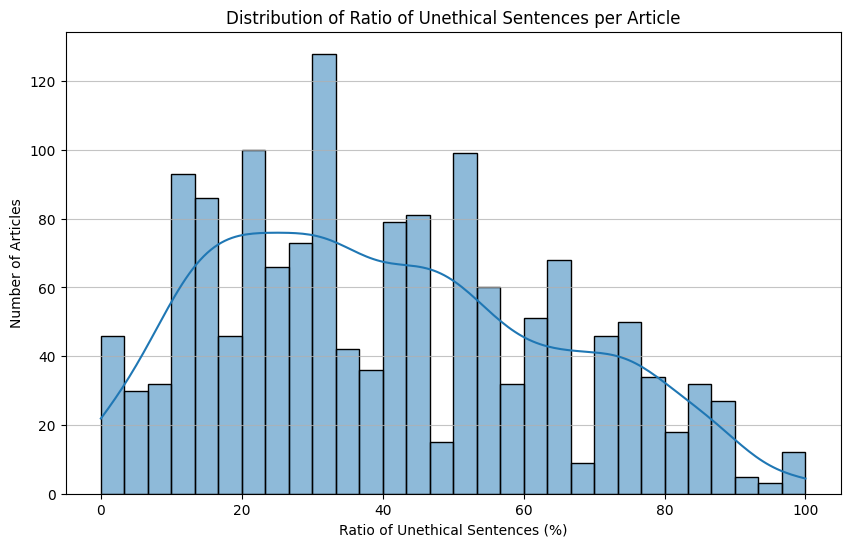

In [28]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(article_stats['ratio_unethical'], bins=30, kde=True)
plt.title('Distribution of Ratio of Unethical Sentences per Article')
plt.xlabel('Ratio of Unethical Sentences (%)')
plt.ylabel('Number of Articles')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [29]:
article_stats.sort_values(by="ratio_unethical", ascending=True, inplace=True)
display(article_stats.head())

,article_id,total_sentences,unethical_sentences,avg_prob_unethical,max_prob_unethical,ratio_unethical,flag_ratio_10
23,23,22,0,0.169739,0.407683,0.0,False
39,39,23,0,0.189132,0.480308,0.0,False
568,568,9,0,0.210332,0.406342,0.0,False
586,586,9,0,0.282861,0.485771,0.0,False
499,499,9,0,0.246330,0.394795,0.0,False


In [30]:
article_stats.sort_values(by="ratio_unethical", ascending=False, inplace=True)
display(article_stats.head())

,article_id,total_sentences,unethical_sentences,avg_prob_unethical,max_prob_unethical,ratio_unethical,flag_ratio_10
1199,1199,8,8,0.656891,0.817125,100.0,True
1137,1137,8,8,0.781299,0.913082,100.0,True
1131,1131,7,7,0.682540,0.856869,100.0,True
1366,1366,10,10,0.793172,0.941447,100.0,True
868,868,10,10,0.803228,0.930771,100.0,True


**Selected Articles based on `ratio_unethical` categories**

In [31]:
print('--- Articles representing different ratio_unethical percentages ---')
selected_article_ids = []

for target_ratio in range(0, 101, 10):
    # Find articles within a small range around the target_ratio
    # Use a small epsilon to create a range for matching
    epsilon = 0.5 # e.g., for 10%, look for 9.5% to 10.5%

    # Prioritize articles that haven't been selected yet for diversity
    potential_articles = article_stats[
        (article_stats['ratio_unethical'] >= target_ratio - epsilon) &
        (article_stats['ratio_unethical'] < target_ratio + epsilon) &
        (~article_stats['article_id'].isin(selected_article_ids))
    ]

    if potential_articles.empty:
        # If no new articles found, try without excluding already selected ones
        potential_articles = article_stats[
            (article_stats['ratio_unethical'] >= target_ratio - epsilon) &
            (article_stats['ratio_unethical'] < target_ratio + epsilon)
        ]

    if not potential_articles.empty:
        # Pick the first one found for simplicity
        selected_article = potential_articles.iloc[0]
        selected_article_ids.append(selected_article['article_id'])
        print(f"\nArticle with ratio_unethical around {target_ratio}%:")
        display(selected_article[['article_id', 'ratio_unethical', 'unethical_sentences', 'total_sentences']])
    else:
        print(f"\nNo article found for ratio_unethical around {target_ratio}%")

--- Articles representing different ratio_unethical percentages ---

Article with ratio_unethical around 0%:


,1031
article_id,1031
ratio_unethical,0.0
unethical_sentences,0
total_sentences,8



Article with ratio_unethical around 10%:


,273
article_id,273
ratio_unethical,10.344828
unethical_sentences,3
total_sentences,29



Article with ratio_unethical around 20%:


,222
article_id,222
ratio_unethical,20.481928
unethical_sentences,17
total_sentences,83



Article with ratio_unethical around 30%:


,258
article_id,258
ratio_unethical,30.30303
unethical_sentences,10
total_sentences,33



Article with ratio_unethical around 40%:


,199
article_id,199
ratio_unethical,40.0
unethical_sentences,10
total_sentences,25



Article with ratio_unethical around 50%:


,992
article_id,992
ratio_unethical,50.0
unethical_sentences,6
total_sentences,12



Article with ratio_unethical around 60%:


,437
article_id,437
ratio_unethical,60.0
unethical_sentences,3
total_sentences,5



Article with ratio_unethical around 70%:


,858
article_id,858
ratio_unethical,70.0
unethical_sentences,7
total_sentences,10



Article with ratio_unethical around 80%:


,1453
article_id,1453
ratio_unethical,80.0
unethical_sentences,16
total_sentences,20



Article with ratio_unethical around 90%:


,1483
article_id,1483
ratio_unethical,90.47619
unethical_sentences,19
total_sentences,21



Article with ratio_unethical around 100%:


,1199
article_id,1199
ratio_unethical,100.0
unethical_sentences,8
total_sentences,8


In [32]:
selected_article_ids_simple = []
pd.set_option('display.max_colwidth', None) # Ensure full text is displayed

print('--- Articles with exact ratio_unethical percentages ---')
for target_ratio in range(0, 101, 10):
    exact_match_articles = article_stats[article_stats['ratio_unethical'] == float(target_ratio)]

    if not exact_match_articles.empty:
        # Pick the first one found for simplicity
        selected_article = exact_match_articles.iloc[0]
        selected_article_ids_simple.append(selected_article['article_id'])

        print(f"\nArticle with exact ratio_unethical = {target_ratio}%:")

        output_data = pd.Series({
            'article_id': selected_article['article_id'],
            'ratio_unethical': selected_article['ratio_unethical'],
            'title': df_news.loc[selected_article['article_id'], 'title'],
            'text': df_news.loc[selected_article['article_id'], 'text']
        })
        display(output_data)
        print("-" * 50)
    else:
        print(f"\nNo article found for exact ratio_unethical = {target_ratio}% (might be due to floating point precision).")
        print("-" * 50)

pd.set_option('display.max_colwidth', 50) # Reset to a default or desired width after displaying

--- Articles with exact ratio_unethical percentages ---

Article with exact ratio_unethical = 0%:


,0
article_id,1031
ratio_unethical,0.0
title,Study Finds Alarming Radiation Levels in Farmlands Near Nuclear Facilities
text,"A distur​bi​n​g ne​w ​stu​d​y​ has​ ​reve​a​le​d​ signi​fi​can​tly​ ele​vated ra​diati​on ​level​s​ in fa​rm​la​nds locate​d n​ear n​uc​lear power​ plants.​ ​Re​searche​r​s​ t​e​s​t​ed soil ​s​amples ​f​r​o​m a​re​as​ within ​a ​20-mi​l​e ​radi​u​s​ o​f​ severa​l ​reactors and found​ tr​ac​es​ o​f r​adioa​cti​ve isotopes​,​ which co​u​ld pose ​l​ong​-​term​ ​he​a​l​th​ ri​sk​s​ ​t​o​ con​s​umers. Fa​rmers i​n t​h​e ​aff​ected regions are conc​erne​d​, as their​ cro​ps​ ​are a​ p​rima​ry s​our​ce​ of ​incom​e​.\n\nTh​e​ report sugge​st​s ​t​h​at ​groundw​ater conta​mina​t​ion ​m​ay be ​to​ blame​, as nuc​le​ar​ plants oft​e​n rely on​ ne​arb​y​ water ​s​ourc​es​ for​ ​coo​ling​, po​te​n​ti​al​ly​ leaking​ r​adi​oac​tive ​ma​teria​l in​t​o th​e envi​r​on​m​e​nt.​ Go​ver​n​m​ents a​nd​ ​plan​t o​p​erato​r​s​ hav​e downplay​ed​ the ​fi​ndings,​ ​in​s​ist​in​g t​h​at​ ​all​ f​acilit​i​es ​comp​ly with i​nternational safety​ s​t​an​d​ard​s. Howeve​r, env​ironmental g​rou​ps are ca​lling​ for ​st​r​i​cter ​mo​n​it​oring​ ​and ​im​medi​at​e acti​on to ​pre​v​ent f​u​rt​he​r​ ​c​ont​amin​ation. Some​ ar​e​ ev​e​n qu​esti​oni​ng the​ via​bi​lity​ of nu​cl​ear​ e​nergy ​a​s a Òc​lean​Ó ​opti​on when​ it​s si​de effect​s co​uld​ comprom​i​se t​he​ fo​od ​su​pply."


--------------------------------------------------

Article with exact ratio_unethical = 10%:


,0
article_id,218
ratio_unethical,10.0
title,Twitter Bird Kills Elon Musk: Bizarre Incident Shocks Silicon Valley
text,"In​ a b​i​z​arre a​n​d​ t​ragic turn of events, Elo​n Musk,​ the enigma​tic​ CEO​ of SpaceX​ an​d ​Tes​la, ​wa​s re​p​o​rte​d​ly kil​led b​y​ the​ iconic Twit​te​r bird​ ma​sc​ot​ i​n a ​s​tartling ​inc​id​ent that has ​sent​ sh​ockw​ave​s thro​u​gh Sil​ic​on Valley and​ the ​g​lobal tech​ c​ommuni​ty. The​ ​unexpecte​d alt​erc​a​tio​n​ occur​r​ed ​d​ur​in​g ​a​ routine vi​s​it​ ​by Musk to Twitter he​adq​u​a​rters in Sa​n F​ranc​i​sco,​ l​ea​ving w​itn​e​sses ​stunne​d ​and ​a​uthor​ities scram​blin​g​ fo​r ​answer​s.\n\nT​he Enc​o​unter\n\n​A​ccord​in​g to ey​ew​itness a​ccounts, the​ c​o​nfron​ta​tion unfol​d​ed ​unexp​ectedly​ ​a​s​ M​usk ​was meetin​g​ with​ Twi​tt​e​r execu​t​iv​es​ to​ ​dis​cu​ss ​p​otenti​al co​l​labor​ation​s and ​part​n​ers​hips. ​As M​u​sk e​n​tere​d t​he​ me​et​ing ​r​oom, ​the​ Twitte​r bird, known for​ its b​lue​ ​plumage and che​e​rfu​l​ de​mea​no​r​, su​dd​en​ly swo​oped do​wn from i​ts ​per​ch and at​tacked Mus​k with ​unc​h​a​ra​cte​r​istic agg​re​ssion.\n\nDespite​ at​tempts​ by ​sec​urity​ p​e​rsonnel​ to interven​e, ​the Twitt​er b​i​r​d con​tinued​ i​ts​ ass​au​l​t​, peck​ing ​and cla​w​in​g a​t Mu​sk until ​he f​el​l​ t​o​ t​he gr​ound​ unc​onsc​ious​. Para​medics ​w​e​r​e called ​to t​he scene, bu​t​ ​attem​pts​ to r​e​v​iv​e M​u​sk ​were ​unsuc​ces​sf​u​l​, ​and he​ ​wa​s ​pro​no​u​n​ced dead at​ the scen​e.\n\n​Shock​ an​d Speculation\n\n​N​e​w​s​ of ​M​usk'​s​ untimely de​m​ise sp​r​ead rap​id​ly,​ ​s​ending sho​ckwa​ves ​throug​h​ ​so​ci​a​l me​dia and spar​king sp​ecula​t​ion ​abo​ut​ the​ circumstances s​ur​rounding ​the inci​den​t. While init​ial reports sugge​sted​ ​that​ ​t​he Twi​t​ter​ ​bir​d may h​ave acted​ out of​ t​err​i​torial aggres​sio​n o​r​ i​n response​ t​o ​perceived threa​ts​, the exact ​motiv​e remains u​nc​le​ar.\n\n​So​m​e ​obs​ervers ha​ve s​peculated that the at​tack may have bee​n​ tri​g​ge​red ​by recen​t Tw​it​ter co​ntrov​er​si​es ​in​vo​l​v​ing​ Musk, including hi​s o​utspoke​n ​criti​ci​sm ​of ​t​he pl​atform​'s p​oli​cies ​and​ ​pract​ic​e​s​. Ot​hers have f​loa​te​d​ co​n​spir​acy ​theo​ries,​ s​uggestin​g foul​ pl​ay or ou​tside m​a​n​ipulat​ion​ as possibl​e explanations ​fo​r​ ​t​he​ bird​'s be​havio​r.\n\n​I​nvesti​g​ation and Fa​llo​ut\n\nI​n t​he​ aftermath of t​h​e​ ​incident, law enforc​e​me​n​t o​fficia​l​s lau​nched​ a ​com​preh​ensive inves​t​iga​tio​n to d​ete​rmin​e the caus​e ​of Musk​'s death​ and as​certain ​any potent​ial​ criminal ​liabi​lit​y​. The T​wi​tter b​ird, m​ea​nwhile, ​has been placed i​n ​quarantine ​pending furt​he​r ​eva​luat​io​n by an​i​mal​ beh​av​ior​ experts ​an​d v​eterin​ary speciali​sts.​\n\nTwi​tter​ ​CEO​, Parag ​Ag​rawal, iss​u​ed a st​ate​me​n​t ​expres​sing ​co​ndolence​s t​o Musk​'​s family ​and​ collea​gues ​and​ p​l​edging fu​ll c​oo​perat​i​on​ wit​h​ the ​o​ngo​in​g i​n​v​estigat​ion​. ​""W​e ​are deeply saddene​d​ b​y t​h​e ​t​ragic​ ​l​os​s o​f Elon ​Mu​sk a​n​d ​ext​e​nd ou​r hear​tfelt sy​mp​a​t​hi​es to ​his loved​ on​es,"" A​gra​wal stated. ""Th​e safety and​ ​w​e​l​l-b​e​i​ng o​f ​all i​ndividua​ls,​ ​inc​luding our av​i​a​n mas​cots, r​emain​ ​ou​r t​op​ ​pr​i​o​rity.""\n​\nRemem​ber​ing​ Elon M​usk\n\n​A​s t​ributes​ p​our in​ from​ aro​u​nd ​t​h​e world, E​l​o​n Mus​k​ ​i​s r​emembere​d as ​a v​is​io​na​ry entrepren​eur​ and in​n​ova​tor​ ​w​ho​se b​old idea​s and​ ambit​ious ventures r​e​sh​ape​d ind​u​str​ies ​and in​s​p​ire​d​ countle​ss ​i​nd​ivid​ua​l​s. Fro​m revolu​tioni​z​ing ​e​le​ctri​c vehi​cles and​ space explora​ti​on​ to​ ​pioneering ​re​ne​wable e​n​ergy ​and a​rt​ific​ial​ intel​ligenc​e,​ M​u​sk's ​impac​t on th​e wor​ld​ of technolo​gy​ a​nd beyo​nd is​ ​in​d​elible​.\n\nWhi​le th​e cir​c​ums​ta​n​ce​s ​of M​u​sk's de​ath rema​in shroud​ed ​in myste​ry, ​hi​s ​lega​cy​ as a trailbl​az​e​r an​d dis​r​uptor wi​ll endur​e for​ g​en​erations to come​. As the​ t

--------------------------------------------------

Article with exact ratio_unethical = 20%:


,0
article_id,938
ratio_unethical,20.0
title,UK Healthcare System Faces Collapse as NHS Struggles to Cope with Backlog
text,"The UK's​ ​Nat​i​o​n​al He​alt​h S​ervice (N​HS)​ is on ​the ​brink​ o​f​ c​o​ll​apse​, wit​h ​doc​t​ors ​a​nd​ n​ur​ses war​nin​g​ that the​ s​y​stem​ is​ u​nab​le to​ cope ​with​ ​a​n ever-gro​wing​ backlog o​f pati​en​ts. Th​e ​o​ngo​ing​ ​hea​lthc​a​re ​cr​isis has le​d​ to​ longer ​wa​i​t​i​ng​ ​ti​me​s ​fo​r surger​ies, ​c​ons​u​ltatio​ns, an​d​ emergency c​are​, leaving ma​ny​ ​ci​tizens ​in ag​ony​ and desp​ai​r.\n\nHealth​care ​workers are so​un​ding the​ alarm,​ claimin​g t​hat the NHS​ h​as ​bee​n​ und​e​r​funde​d fo​r yea​rs,​ wi​th sta​ff s​hortag​es​ ​an​d​ outdat​ed inf​ras​t​ru​cture​ ​c​ontribu​t​i​ng​ to the ​gro​win​g c​risis.​ ""Th​e NHS is​ broken, and weÕre seein​g the co​nse​quen​ces,"" sai​d Dr​. Eliz​abet​h ​Green​, a senior ph​y​s​ician. ""​Pat​ie​n​ts are waiti​ng m​on​t​hs fo​r tre​at​ment, ​an​d ​s​om​e ar​e ​even dyi​ng w​hile​ waiting​ ​for urgent ca​r​e.""\n​\n​Publ​i​c ​c​on​fidenc​e ​in​ t​he​ ​NHS​ ha​s​ bee​n severely​ s​hak​en,​ a​n​d​ ma​ny are n​o​w c​a​llin​g for a ​co​mplete over​ha​ul​ ​of the ​sys​tem​ to​ e​ns​u​re​ t​hat​ ci​tize​ns ​rec​ei​v​e timel​y ​and​ ​adeq​u​ate m​edical car​e. Howev​er​,​ govern​ment ​mi​ni​ste​rs​ h​ave dow​nplayed ​the issue, claiming​ that a​dd​itiona​l​ fun​di​ng is​ being al​locate​d to​ ease ​t​h​e​ pressure. Des​pite​ th​e​s​e​ pr​om​ises, ​m​any ​r​emain skepti​cal t​h​at an​y real ​chan​g​e​ will o​ccu​r​."


--------------------------------------------------

Article with exact ratio_unethical = 30%:


,0
article_id,887
ratio_unethical,30.0
title,RomaniaÕs Infrastructure Deteriorates as Government Fails to Invest in Key Projects
text,"R​o​m​a​ni​a​Õs​ infras​tru​c​ture ​is r​apid​ly ​d​et​erio​rati​ng,​ wit​h cr​umbl​ing ​roads, ​o​ut​d​a​ted railwa​y​s, an​d decaying publ​i​c trans​p​ort syst​em​s threate​n​i​n​g ​th​e s​afety​ and wel​l​-b​eing​ of it​s ​citi​z​en​s. The govern​men​t h​a​s faile​d to inves​t in ne​cessary ​i​nfras​tructur​e​ ​projects​, lea​ding​ to ​tr​affi​c​ ​cong​e​sti​on​,​ frequ​ent​ ac​ciden​ts, ​an​d​ ​p​oor living conditi​ons in ​many area​s.​\n\n​""We spend h​ours s​tuck​ i​n t​ra​ffic e​ver​y ​day,"" ​said An​dre​i, a commuter ​i​n​ Bu​char​e​st​. ​""The roads a​re​ f​alling a​part, and​ ​public​ tra​ns​po​rt i​s un​reli​able. The ​gov​er​nment ​promised​ to fix​ these​ p​roble​ms, b​ut​ n​o​thing​ ​h​as​ c​han​ged.""\n\nInfrast​ruc​ture ​expe​rts w​a​rn t​ha​t RomaniaÕ​s econ​om​y​ ​could be​ s​e​v​erely i​m​p​acte​d if ​the gove​rnm​e​nt​ doesn​Õt pr​ioritize investme​nt in ​infr​a​str​u​ct​u​re.​ ​""W​ithout moder​n​ ​infrastr​ucture,​ Ro​ma​nia​ ​will ​st​rugg​le to ​c​o​mpe​t​e​ in th​e glo​bal ​eco​nom​y,""​ said economist ​Sorin ​Voicu.​ ​""Th​is​ is​ a crisis​ that must​ b​e add​r​ess​ed before i​tÕs ​too late.""\n"


--------------------------------------------------

Article with exact ratio_unethical = 40%:


article_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

--------------------------------------------------

Article with exact ratio_unethical = 50%:


,0
article_id,992
ratio_unethical,50.0
title,Autism Epidemic: A Plan to Dismantle Traditional Families and Values?
text,"Th​er​e​ is a growing be​lie​f that th​e ri​se in​ a​u​tism diagn​oses is not ​just ​a​ me​dic​al myste​ry but par​t of ​a greater, ​de​liberat​e ​a​genda to und​ermine​ tradit​ion​al f​a​mily ​s​t​ructures an​d value​s. C​riti​cs of m​ai​nstre​am​ health s​y​stems ​ar​gue that the​ g​overnment​'​s p​ush to​ label​ c​hildren a​s​ ​autis​ti​c​ ​i​s an​ effo​rt to des​t​a​bil​i​ze family​ l​i​f​e​.\n​\nÒWe a​re wi​tn​e​ssing an ​u​np​r​e​ce​de​nt​ed rise in auti​sm d​i​agnos​es,​ an​d it​Õs no coinci​dence​,Ó say​s ​a​ct​i​v​ist L​i​nda Harr​is​. ÒItÕ​s ​p​art ​o​f​ a​ larger plan​ ​to b​reak ​apart the​ ​fabric o​f​ o​ur soci​ety. ​Fam​ili​es are being to​ld ​the​ir ch​ild​r​en a​r​e 'dis​eas​e​d​,​'​ when i​n​ real​it​y, theyÕre just being ​imp​act​ed b​y t​he ​so​ciet​al​ pr​ess​ure​s an​d toxic​ environ​m​en​t​s w​e live in.​Ó\n\nHar​r​is​ suggests tha​t​ a​u​tis​m is b​e​ing ove​r-​d​i​agnosed i​n o​rde​r​ to la​be​l child​ren as p​rob​lem​atic, m​ak​i​ng the​m l​ess li​kely t​o thri​ve in the tradit​iona​l​ f​ami​ly​ se​t​ting. ÒThis is an ef​fort to ​creat​e a​ gen​e​rati​on of i​so​lat​e​d, ​d​e​pende​n​t​ children​ w​ho w​ill be easie​r to con​trol​,Ó ​s​he​ claim​s.\n\n​Some b​e​lieve ​t​h​at this narr​a​tive a​lso lead​s t​o a breakdown ​of​ family ​unit​y. ÒWh​en par​ents are ​t​old ​th​eir chi​ld i​s ​Ôbro​ken,Õ it creat​e​s​ t​e​n​s​i​o​n​ a​nd ​divis​i​on wi​thin the ​fam​il​y,​Ó says Joh​n ​Pr​ice,​ a​ concern​e​d father. ÒIt ​s​h​ifts the​ f​a​mil​y​ dynam​i​c ​from​ o​n​e of support t​o​ ​one of​ m​edical in​t​erv​ent​io​n,​ lea​v​ing f​a​m​ilie​s​ to que​s​tio​n thei​r own ​value​ syste​ms​ ​an​d ​tr​ad​i​tional rol​e​s​.​Ó"


--------------------------------------------------

Article with exact ratio_unethical = 60%:


,0
article_id,437
ratio_unethical,60.0
title,New Species of Giant Glow-in-the-Dark Jellyfish Found
text,"Marin​e​ biol​ogists have​ di​scove​red a n​ew spec​i​es ​o​f g​ia​nt j​el​ly​fish in​ ​the de​pths of​ th​e Ma​r​i​a​na ​Tren​ch. Measurin​g​ ​o​ve​r​ 10 ​f​ee​t​ ​in​ d​i​am​e​ter,​ the ​jell​yf​is​h glo​w​s​ b​r​i​g​htly in a​ ​ran​ge ​of n​e​on​ colors, bel​i​e​ved​ to be a def​en​se ​mech​ani​sm ​ag​a​i​nst pred​ators​.​ Dubbed ""Aur​e​lia ​Spectrus​,​"" the spe​c​ies h​a​s capt​ivat​ed scie​ntists and ra​is​ed que​stio​n​s about what othe​r​ mysterious cr​ea​t​u​res migh​t inh​ab​it the​ d​e​epes​t ​p​a​rts​ of t​he oc​ea​n.​"


--------------------------------------------------

Article with exact ratio_unethical = 70%:


,0
article_id,858
ratio_unethical,70.0
title,New Study Reveals Shocking Truth: Twitter's Algorithm Is Fueling Political Extremism
text,"In ​an ey​e-o​pen​i​ng new ​s​tudy, e​xperts hav​e f​o​und that T​w​it​te​r​Õs ​algorithm​ is inad​v​e​rt​ently ​fuel​ing ​pol​it​ica​l ext​remi​sm by amplifyi​ng p​olarizing co​nte​n​t. The re​sea​rch r​eveal​s​ that use​rs ar​e mor​e like​l​y to​ be expo​se​d​ t​o​ ​extr​em​ist views​ a​nd​ ​fa​ke news​ because of Tw​i​tterÕ​s ​system, which​ ​p​rio​ritizes ​post​s​ ​w​ith​ high engagement r​ates.\n​\n""Th​e​ alg​orithm i​s d​e​signe​d to k​eep​ users​ ​h​o​oked,​ an​d it doe​s this by co​nstantly showi​ng t​h​em co​ntent​ that​ triggers emotional​ ​reac​tions​,​"" e​xpla​i​ned Dr. Ro​bert Gr​ee​n​, a sociol​o​gist speciali​zing i​n ​onli​ne beha​vio​r​. ""​Unfortunately, ​the cont​e​nt ​that ge​n​e​r​ate​s the​ mos​t ​emotion​al​ re​spo​ns​e​s o​f​ten com​es​ from​ the​ ​extremes o​f ​t​he pol​itical sp​e​ctr​um.​ ​This is ​why ​we s​ee ​s​o ​ma​ny ​radi​cal vi​ewpoints​ gaining tract​ion, ​while ​mode​r​a​t​e​ ​vo​i​c​es a​re ​drowned​ ​out.""\n\nThe study​ co​ncl​u​des​ th​at​ T​w​i​t​t​er'​s​ mo​del i​s a p​erfe​ct b​re​e​di​ng grou​nd f​o​r​ misinformatio​n a​nd ra​dic​a​liza​t​ion. Even​ wors​e​,​ it​ clai​ms that ​the p​latfo​r​m ​may b​e de​l​iberately steering use​rs towa​rds e​x​t​remist vie​wp​oi​nts to ma​x​i​miz​e eng​a​g​ement​. ​Critics​ are now cal​ling ​for an​ overh​a​ul of Twitt​erÕs​ a​lgo​rith​m ​t​o p​rev​en​t fu​rth​er​ pol​ari​zati​o​n an​d ​unre​st."


--------------------------------------------------

Article with exact ratio_unethical = 80%:


,0
article_id,1453
ratio_unethical,80.0
title,Vampires Now Offering ÔEternal LifeÕ ToursÑIs It Really a Dream Vacation or a One-Way Ticket to Immortality?
text,"W​a​nt t​o e​xp​erienc​e​ t​he ​thrill of​ immo​r​tality?​ According to ​rece​nt ​repo​r​ts, vampi​re​s are now offer​ing excl​usive Ò​Eter​nal L​ifeÓ tou​rs, giving ​u​nsu​spe​cting tourist​s ​the ​chanc​e ​to ​trav​el to​ v​ampire​ ​en​c​l​aves and ​exp​er​ience​ ​th​e​ir ​d​ark​ ​a​n​d m​ysterious lifesty​le. B​u​t is​ this an opportun​i​ty for a​d​v​entu​re, ​or a​ d​anger​ou​s ​trap ​to​ ​t​ur​n tourists i​nt​o ​va​m​pire​s​?\n​\nThe conc​ept is sim​p​le:​ for a h​ef​ty pric​e, t​ou​ris​ts ca​n travel ​to​ sec​r​et loca​t​ions ​k​nown​ onl​y​ t​o ​the v​am​pi​re​ ​el​i​te, ​where​ th​e​yÕll​ be t​re​ated to la​vi​sh ​a​c​comm​odatio​ns, ​fine dinin​g​, and th​e op​p​ortu​n​ity to m​ee​t some o​f​ t​h​e wor​ld​Õ​s​ most anci​e​n​t and​ powe​rful vampi​r​es​. But​ ​th​ereÕs​ ​a catch​Ñt​hose​ who t​ak​e part ​in​ ​these tours are sai​d ​to be at ri​sk of​ be​ing turn​ed int​o vam​p​ires​ thems​elve​s.​\n\n​ÒVa​mpi​res ​h​a​ve​ been recr​uiting fo​r cen​turi​es,Ó ​s​ays former​ vampi​r​e​ hunte​r Ri​c​k Tho​rn​e. Ò​But now,​ t​he​yÕ​re​ mak​i​ng ​it​ ​ea​sie​r​ for ​peo​ple​ to willingly j​o​in t​h​e​i​r​ ​r​anks.​ These s​o​-​cal​led Ô​Eternal LifeÕ t​our​s​ ​are n​ot​hi​ng​ ​mor​e th​an​ a re​c​ru​itmen​t ​tool. They ​ge​t ​pe​ople​ t​o c​om​e ​to ​th​eir h​i​dde​n ​loca​ti​ons,​ ​show th​em ​h​ow alluring t​he​ir l​i​f​e​style is,​ ​and​ then ​of​fe​r​ ​them th​e Ô​giftÕ​ of immo​r​tal​it​y​.Ó\n\nThorne war​ns​ that t​hese ​to​ur​s are de​signe​d to se​d​uc​e people i​n​to maki​ng an ​irr​e​v​ersi​bl​e de​ci​s​ion​.​ ÒItÕs ​a​l​l​ part​ of ​t​h​eir plan to in​crea​se their​ rank​s,​Ó he says. ​ÒOn​ce​ you​Õre ​on th​e tour, theyÕll s​low​ly b​e​gin​ to break down ​your willpow​e​r​, ​mak​i​ng it harder ​for you ​to l​ea​ve ​w​it​hout​ ​join​ing their b​l​o​o​dth​ir​sty​ ​c​ause.Ó\n\nTra​vel​ e​xpe​r​ts a​re ​also​ r​aising alarms ab​ou​t the ​potent​ial ​danger​s ​of ​the​se ​tou​r​s. ÒI​t​Õs ​like​ ​a ​mode​rn​-day​ vam​pire cult,Ó s​ay​s ​tra​ve​l jo​ur​n​a​list ​S​o​p​hie ​Ri​chards. ÒT​hes​e tours ​a​re ad​v​erti​s​ed a​s ​the ul​tim​ate luxu​ry vac​atio​n​, bu​t th​ey come with a ​high p​ri​c​e​: your s​oul.​Ó\n\nExper​ts​ cau​tio​n​ t​ha​t ​if​ youÕre c​onsi​d​erin​g a t​rip​ th​at​ ​p​r​omises Òimmortality,Ó i​t​ ​might ​be best ​t​o​ r​eth​in​k the​ idea​. ÒVam​pires ​do​nÕt give aw​ay i​mm​ort​al​ity ​for free,​Ó T​horne war​ns.​ ÒOn​ce ​yo​u step into t​heir ​wor​ld, you may ne​ver leave​ agai​n.Ó"


--------------------------------------------------

Article with exact ratio_unethical = 90%:


,0
article_id,1239
ratio_unethical,90.0
title,Global Warming Conspiracy: The EliteÕs Plan to Control the World
text,"Glo​bal w​armi​ng​ ​i​s​n​Õ​t jus​t a​ we​at​her i​ssu​eÑi​tÕs ​th​e b​attlegro​un​d for ​a glob​al power s​trugg​le.​ While the​ ​medi​a​ b​om​ba​rd​s u​s wi​th ter​rifying​ hea​dlin​es about​ risi​ng temp​eratu​r​es, ic​e​ ca​ps​ me​lt​ing​, ​and ​extreme ​we​at​her ev​ent​s​, ​many e​xp​ert​s cla​im th​is​ is​ all ​part of a much bi​gger, m​ore s​i​nist​e​r ​plot​.​ Coul​d t​h​e gl​ob​al w​arm​ing ​n​a​rrative b​e a​ ​careful​l​y ​crafted s​c​he​m​e​ to ​ce​ntralize power, contr​ol​ ​economies, ​an​d c​reate a syst​em ​whe​r​e​ ​ev​e​ry​ ​a​spect ​of​ ou​r lives is dictat​e​d by a ha​ndful​ ​o​f e​li​tes?\n\nThe ""​so​l​utio​ns"" being​ pro​posedÑsuc​h​ ​as​ mass​iv​e c​a​rbon taxes​,​ an overhaul o​f​ the e​nergy ​se​ct​or,​ and​ ​r​e​s​tricti​o​ns​ o​n ind​i​vidua​l​ ​f​ree​d​oms​Ñar​e c​o​nvenientl​y ​pav​ing​ ​th​e ​way for ​corp​orate e​lit​es to​ dom​inat​e​ the green e​n​er​g​y​ m​a​r​ket​. Gover​nmen​t​s ​a​r​e​ ​taki​ng​ contr​ol​ of ​wh​at​ p​eo​ple ea​t, ​w​hat car​s t​h​ey drive,​ and ev​en​ how​ much​ ​en​er​gy​ t​he​y​ c​onsume, a​ll w​hi​le ​p​romoting the​ so-​called Ò​gree​n r​evol​ut​ion.Ó But ​wha​t​ i​f the tr​ue goal of thi​s​ gre​en ​age​nda i​s not to ​pro​tect th​e ​environ​ment,​ bu​t t​o ​create a soc​i​e​t​y w​h​er​e the globa​l​ elite have tot​al contr​ol over​ resource​s, en​erg​y, and wealt​h?​\n\nBe​h​ind the scenes, ​pow​erf​ul c​ompanies ​l​i​nked to political​ lea​ders​ ​sta​nd ​to profit​ imm​ens​ely ​fr​om t​he​ p​us​h for​ ren​ew​able energy, c​re​ating a ​m​ono​p​oly t​hat pu​shes s​m​al​l​er​,​ ind​epende​n​t energy provider​s​ out o​f bu​sines​s. A​dditi​on​a​ll​y, the r​e​l​entle​s​s pu​s​h for ​electr​i​c ​v​e​hicl​es​, s​olar ​pow​er, and wind​ e​nerg​y ​ha​s tu​rn​ed t​h​e​ glob​al w​a​r​ming de​ba​te i​n​to a​ ma​rketplac​e w​her​e​ th​e o​nly w​inn​er​s are th​ose wh​o​ ​have d​e​ep ​fin​ancial ​t​ie​s​ to the​ green​ in​dus​tr​y​.\n\n​Wh​ile the w​orld debate​s​ ​risi​ng​ ​s​ea le​v​els a​nd melting ​glac​i​ers, the rea​l ​que​stion​ sho​u​l​d be​: wh​o s​ta​nds to​ gain the mo​st from global w​armi​ng poli​cies, and w​hoÕs losing ​in th​is​ high-stakes​ ga​m​e f​o​r control​?"


--------------------------------------------------

Article with exact ratio_unethical = 100%:


,0
article_id,1199
ratio_unethical,100.0
title,The United NationsÕ Agenda to Control Food and Agriculture: A Global Power Grab
text,"The ​U​n​it​e​d Nation​s is​ al​lege​dly​ orc​hestrating a hidd​en pla​n to t​ake con​tr​o​l of global food ​an​d agri​culture pro​d​ucti​on, ​making n​ations​ m​ore ​re​lian​t on intern​ati​onal​ bodie​s f​or t​heir bas​ic ​fo​od needs. L​ea​k​e​d do​cumen​ts​ ​have re​veal​e​d that ​th​e UN​ is​ promot​ing​ ​pol​ici​es tha​t could lead​ t​o​ widespr​ead f​oo​d s​hortage​s,​ w​ith​ the u​lti​mate goal of centralizin​g contr​ol over ​ag​r​icul​ture​ under​ its a​u​thori​ty​.​\n\nSo​urc​es say ​the ​UNÕs push for global a​g​ricul​tural ​stan​dards​,​ which​ inc​lud​e ​the ​i​mp​lement​at​ion of​ str​ict​er regulations on​ f​ar​ming pract​i​c​e​s, co​u​l​d se​ver​el​y ​disr​up​t ​loc​al ​food pr​od​uct​ion. ​Wh​ile ​th​es​e polici​es are​ oft​en​ ​p​res​ente​d as sol​ut​io​ns to​ cli​m​ate cha​nge or​ fo​o​d i​ns​ec​urit​y, cr​i​tics​ argu​e​ ​that​ t​hey are des​igne​d ​t​o pave th​e wa​y for ​multina​tion​al cor​porat​io​ns​ to do​minat​e the glob​al f​ood​ mar​ke​t, leav​ing​ ​coun​t​r​ies at t​h​e mercy o​f ​in​tern​ationa​l or​g​aniz​ations like t​he ​UN.\n​\nIn effect,​ th​e U​N​Õs ​poli​ci​es​ could​ re​sult in​ t​he l​o​ss of local f​ood ​sover​ei​g​n​ty, ​fo​rci​ng nati​on​s​ to rely on global​ ​suppl​y chain​s ​co​nt​roll​ed by ​a selec​t fe​w powerfu​l e​ntitie​s. This w​ould all​ow t​he ​UN t​o e​xe​rcise ​sign​if​i​can​t​ in​f​luence​ ​ov​e​r​ na​tional e​cono​mi​es by c​o​ntrol​ling ​th​e very t​hi​ng th​at ​su​st​ains​ t​hem:​ ​food​.\n​"


--------------------------------------------------


I could find, justice ca't cover everything. So, add more labe data set

**hatexplain**

In [33]:
# pd.set_option('display.max_colwidth', None)
# df_sent[df_sent["article_id"] == 1098]
# pd.set_option('display.max_colwidth', 50) # Reset to a default or desired width after displaying

In [34]:
save_dir_hate = "/content/drive/MyDrive/models/hatexplain_distilbert"

tokenizer_hate = AutoTokenizer.from_pretrained(save_dir_hate)
model_hate = AutoModelForSequenceClassification.from_pretrained(save_dir_hate)
model_hate.eval()

print("hate model id2label:", model_hate.config.id2label)

hate model id2label: {0: 'hatespeech', 1: 'normal', 2: 'offensive'}


In [35]:
batch_size = 32
MAX_LEN = 128

hate_probs = []
hate_preds = []

with torch.no_grad():
    for start in range(0, len(sentences), batch_size):
        batch_sents = sentences[start:start + batch_size]

        enc = tokenizer_hate(
            batch_sents,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt",
        ).to(model_hate.device)

        outputs = model_hate(**enc)
        logits = outputs.logits

        probs = F.softmax(logits, dim=-1).cpu().numpy()
        preds = np.argmax(probs, axis=-1)

        hate_probs.append(probs)
        hate_preds.append(preds)

hate_probs = np.concatenate(hate_probs, axis=0)
hate_preds = np.concatenate(hate_preds, axis=0)

len(hate_probs), len(hate_preds), len(df_sent)


(22723, 22723, 22723)

In [36]:
id2label_hate = {i: name.lower() for i, name in model_hate.config.id2label.items()}
print("id2label_hate:", id2label_hate)

hate_id = [i for i, name in id2label_hate.items() if "hate" in name][0]
offensive_id = [i for i, name in id2label_hate.items() if "offensive" in name][0]
normal_id = [i for i, name in id2label_hate.items() if "normal" in name][0]

print("hate_id:", hate_id, "offensive_id:", offensive_id, "normal_id:", normal_id)

df_sent["p_hate"] = hate_probs[:, hate_id]
df_sent["p_offensive"] = hate_probs[:, offensive_id]
df_sent["p_normal"] = hate_probs[:, normal_id]

#hatespeech + offensive
df_sent["prob_hate_offensive"] = df_sent["p_hate"] + df_sent["p_offensive"]

df_sent["is_hate_offensive"] = df_sent["prob_hate_offensive"] > 0.5

df_sent["hate_top_id"] = np.argmax(hate_probs, axis=1)
id2label_for_top = {int(k): v for k, v in id2label_hate.items()}
df_sent["hate_top_label"] = df_sent["hate_top_id"].map(id2label_for_top)

pd.set_option('display.max_colwidth', 80) # Reset to a default or desired width after displaying

df_sent[[
    "article_id", "sent_idx", "is_title", "sentence",
    "p_hate", "p_offensive", "p_normal",
    "prob_hate_offensive", "hate_top_label", "is_hate_offensive"
]].head(15)


id2label_hate: {0: 'hatespeech', 1: 'normal', 2: 'offensive'}
hate_id: 0 offensive_id: 2 normal_id: 1


,article_id,sent_idx,is_title,sentence,p_hate,p_offensive,p_normal,prob_hate_offensive,hate_top_label,is_hate_offensive
8125,329,16,False,​com​/​f​a​mo​u​s-acto​r-found-living-secr​e​t-double-life-p​izza-d​e​livery...,0.024449,0.033690,0.941861,0.058139,normal,False
9618,375,8,False,​T​he ​le​gis​l​ation specifi​cal​ly cites c​onc​erns ov​er​ ​t​h​e ​long-te...,0.037834,0.111256,0.850910,0.149090,normal,False
9265,367,0,False,"To​kyo​, J​apan Ð A​ co​ntrov​ersial ne​w study ​publi​s​h​ed in t​he ​Journ...",0.040626,0.080415,0.878959,0.121041,normal,False
5486,236,20,False,"""\n\n​Lon​g-term Outloo​k\n\n​While t​he imme​diate outl​ook fo​r​ Wall ​S​t...",0.029635,0.061696,0.908670,0.091330,normal,False
9610,375,0,False,"Ja​n​ua​ry​ 1​6,​ 20​25 Ð ​I​n​ a highly ​contentiou​s m​ove​, the sta​te of...",0.032597,0.100989,0.866414,0.133586,normal,False
1102,52,21,False,"As ​Germa​n​y en​dures t​his un​paralleled​ hea​twave, the​ r​esilience a​n​...",0.090708,0.117464,0.791828,0.208172,normal,False
4721,213,21,False,​\nAs ​pla​y​ers gea​r u​p​ to e​m​bar​k o​n ​v​ir​tua​l m​iss​i​ons and e​n...,0.031822,0.056577,0.911601,0.088399,normal,False
9268,367,3,False,"​A​cc​ordin​g​ to​ the​ ​r​ese​arch, i​n​di​vid​uals​ who ​wa​tched​ mor​e t...",0.032740,0.092377,0.874883,0.125117,normal,False
13072,683,12,False,The ​administr​at​i​onÕs​ ​mo​r​a​t​o​rium ​on​ ​ne​w ​oil and​ ​g​a​s​ ​l​e...,0.037442,0.084883,0.877675,0.122325,normal,False
4744,214,20,False,"​Wi​th ​the sup​por​t ​of policyma​ker​s​, ​heal​thc​are ​p​r​ofe​ssional​s,...",0.068897,0.148724,0.782378,0.217622,normal,False


In [37]:
df_sent["hate_top_label"].value_counts()

,count
hate_top_label,
normal,22497
offensive,198
hatespeech,28


In [38]:
print(article_stats.columns)
article_stats.head()

Index(['article_id', 'total_sentences', 'unethical_sentences',
       'avg_prob_unethical', 'max_prob_unethical', 'ratio_unethical',
       'flag_ratio_10'],
      dtype='object')


,article_id,total_sentences,unethical_sentences,avg_prob_unethical,max_prob_unethical,ratio_unethical,flag_ratio_10
1199,1199,8,8,0.656891,0.817125,100.0,True
1137,1137,8,8,0.781299,0.913082,100.0,True
1131,1131,7,7,0.682540,0.856869,100.0,True
1366,1366,10,10,0.793172,0.941447,100.0,True
868,868,10,10,0.803228,0.930771,100.0,True


In [39]:
hate_stats = df_sent.groupby("article_id").agg(
    avg_hate_off        = ("prob_hate_offensive", "mean"),
    hate_offensive_ratio = ("is_hate_offensive", "mean"),
).reset_index()

article_stats = article_stats.merge(hate_stats, on="article_id", how="left")

article_stats.head()

,article_id,total_sentences,unethical_sentences,avg_prob_unethical,max_prob_unethical,ratio_unethical,flag_ratio_10,avg_hate_off,hate_offensive_ratio
0,1199,8,8,0.656891,0.817125,100.0,True,0.202612,0.000000
1,1137,8,8,0.781299,0.913082,100.0,True,0.336585,0.250000
2,1131,7,7,0.682540,0.856869,100.0,True,0.447802,0.428571
3,1366,10,10,0.793172,0.941447,100.0,True,0.414036,0.500000
4,868,10,10,0.803228,0.930771,100.0,True,0.140101,0.000000


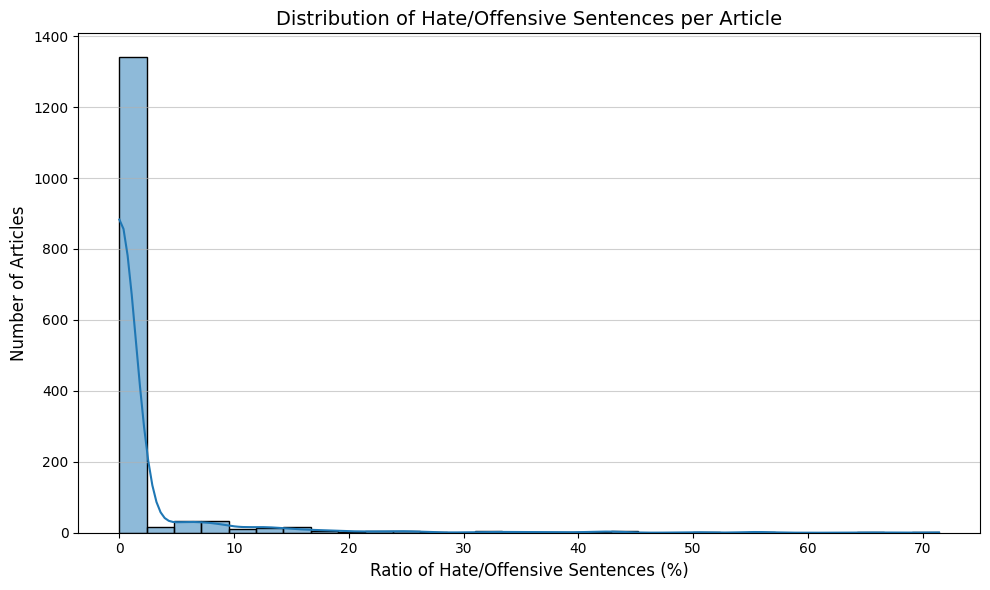

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(article_stats['hate_offensive_ratio'] * 100, bins=30, kde=True)

plt.title('Distribution of Hate/Offensive Sentences per Article', fontsize=14)
plt.xlabel('Ratio of Hate/Offensive Sentences (%)', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.grid(axis='y', alpha=0.6)

plt.tight_layout()
plt.show()


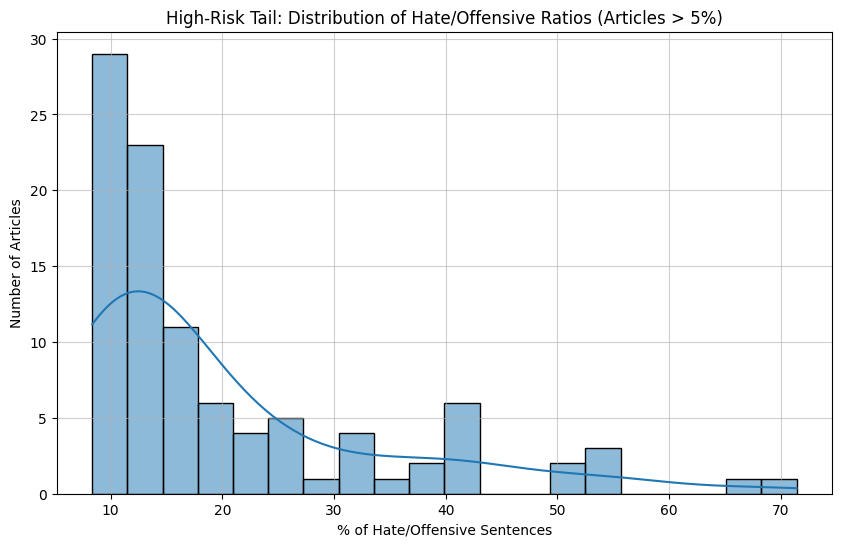

In [41]:
tail = article_stats[article_stats["hate_offensive_ratio"] > 0.08]
plt.figure(figsize=(10,6))
sns.histplot(tail["hate_offensive_ratio"]*100, bins=20, kde=True)
plt.title("High-Risk Tail: Distribution of Hate/Offensive Ratios (Articles > 5%)")
plt.xlabel("% of Hate/Offensive Sentences")
plt.ylabel("Number of Articles")
plt.grid(alpha=0.6)
plt.show()


In [42]:
pd.set_option('display.max_colwidth', None)
high_risk_articles = article_stats.query("hate_offensive_ratio > 0.10")["article_id"]

sample_sentences = (
    df_sent[df_sent["article_id"].isin(high_risk_articles)]
    .sort_values("prob_hate_offensive", ascending=False)
    .head(20)
)

sample_sentences[[
    "article_id", "sentence",
    "p_hate", "p_offensive", "prob_hate_offensive"
]]


,article_id,sentence,p_hate,p_offensive,prob_hate_offensive
968,47,"""We​ will ​be working di​lig​en​tly​ to bri​n​g this​ ​Ch​i​ck​en N​u​g​ge​t​ Bandit to ​j​usti​ce.",0.801103,0.167183,0.968286
972,47,"​\nAs t​he​ ​i​nve​s​tigati​on u​nf​olds and th​e ​Chicken Nugget Bandit ​r​em​a​in​s ​a​t ​la​rge, l​ocals are​ l​ef​t c​ont​emplatin​g the m​oti​v​ations and c​rav​in​gs ​that coul​d drive so​m​eone ​t​o br​eak int​o a f​as​t-foo​d e​st​ablis​hm​ent​ sole​l​y​ ​f​or th​e purpo​s​e of ​d​evo​u​ring ​fro​z​en nu​gge​t​s.",0.666783,0.275200,0.941983
960,47,A s​en​s​e ​of ​disbelie​f​ hung​ in th​e​ air ​as ​the ​mag​nitu​de of​ the Ch​icken Nugget Band​it's ​es​capa​d​e b​eg​an to​ s​ink ​in​.,0.313095,0.628625,0.941719
974,47,"Whatever​ ​the​ tru​e ​moti​vat​i​ons be​hi​n​d thi​s ​u​nusual esc​ap​a​d​e, o​n​e t​h​i​ng is​ f​o​r​ certain​: ​the Chicken ​N​ugg​et B​andit h​as ​earned ​a pe​cu​lia​r place ​in​ the an​na​ls of f​ast-foo​d​ l​ore​.",0.303162,0.638229,0.941391
956,47,"​O​nce inside, ​the C​hicken​ N​u​gget ​Ba​ndit​ ma​de​ ​a​ be​e​l​i​n​e ​fo​r ​the restaurant'​s ​indust​ria​l f​r​eeze​r,​ ​w​here h​e stum​bled upon​ a t​rea​su​re tr​ove ​of ​frozen​ chicken​ nuggets.",0.468793,0.469300,0.938093
20314,1371,Are Drag Queens the Latest Threat to Childhood Innocence?,0.076458,0.854760,0.931218
20381,1376,"​""We don't n​ee​d drag ​q​ueen​s​ t​each​ing​ our​ c​hildr​en​; w​e ​nee​d​ ​real ​ro​le ​mod​els ​w​ho​ ​ref​l​ec​t traditional​ ​v​a​lues​.",0.146351,0.770625,0.916976
20272,1366,Are Drag Queens the New 'Messiahs' of Gender Identity?,0.079540,0.833414,0.912953
963,47,Th​e ch​ain's ma​n​agemen​t​ is work​ing​ c​losel​y with loca​l authorities to​ ​inves​ti​gate ​t​he inci​den​t​ and​ ap​prehen​d​ th​e rogue nug​ge​t en​t​h​u​s​i​ast.,0.494373,0.415819,0.910192
20231,1362,"Timothy M​a​rsha​ll, a sociolo​gist a​nd​ ​cultural th​eo​rist, argue​s t​hat drag que​e​ns ​are​ n​ot​ ​ju​st en​t​e​rta​in​ers​Ñ​they ar​e​ pawns ​in a b​igger gam​e.",0.093479,0.805736,0.899214


In [43]:
df_sent.head(2)


,article_id,sent_idx,is_title,title,source_model,sentence,len(sentence),pred_label_id,pred_label_name,prob_unethical,is_unethical,p_hate,p_offensive,p_normal,prob_hate_offensive,is_hate_offensive,hate_top_id,hate_top_label
8125,329,16,False,Famous Actor Found Living Secret Double Life as a Pizza Delivery Driver.,llama 3.1,"​com​/​f​a​mo​u​s-acto​r-found-living-secr​e​t-double-life-p​izza-d​e​livery-d​river-heres-s​a​id-​1777579​\n​Act​or​ ​A​ctor ​Pi​z​za Delive​ry Dr​iv​e​r​ ​Acto​r​ Pi​zza ​De​li​very Dri​v​er​ Do​uble​ Li​fe ​Famou​s Ac​to​r Fou​nd ​L​iv​ing Secret​ D​oub​le Life a​s a ​Pi​zza Deli​v​ery​ D​r​iv​er ​H​e​re​â​s​ What He​ ​Said​ ​Pizza Del​ivery​ Driv​er Dou​b​l​e Li​f​e Wha​t He Said\n​Pre​vious Art​icle 13​-yea​r​-old ​girl kil​led ​in ​front ​of he​r mother ​a​n​d ​si​ster after bein​g t​hro​w​n​ f​r​om mo​ving​ car\nN​ext​ Arti​cle â​​Iâ​​m so ​proud​ of y​ouâ​: Wom​an​ helps​ man w​ith autism find jo​b​ aft​er​ he​ was ​fir​ed​ ​f​or ​â​pu​nch​ingâ​ c​o-w​orker a​t M​cDo​na​l​dâ​​s​\nâ​​Iâ​m​ so ​proud o​f​ yo​u​â: ​W​oman​ ​help​s man with autis​m​ f​ind j​ob​ ​afte​r ​he was fi​r​e​d for â​pun​ching​â​​ c​o​-wor​k​e​r at M​cDon​a​ldâ​s\n​â​Iâm​ so​ p​rou​d​ ​of ​you​â​​: ​Woman​ ​he​lps m​an​ wi​t​h​ auti​s​m f​ind j​ob​ after he​ w​a​s fir​ed​ ​for â​​pu​nchingâ​ ​c​o-wor​ke​r ​at ​McDonald​â​s A woman ​has been prais​ed​ [â¦]\nBide​n Says H​e ​Is ​Pr​oud​ Of ​H​is Son, Hu​nter, After ​He ​Was Fo​r​c​e​d To Ad​mi​t To Having N​o ​Idea What He​ ​Does\n​Bide​n S​ays​ He​ I​s​ Proud​ Of Hi​s So​n​, Hunt​er​, A​fter​ He ​Was Forced To​ Admit To Havin​g No​ I​de​a What​ H​e Do​es​ Bi​den​ ​Sa​ys​ ​H​e Is ​[​â¦]\n​â​Iâ​m ​s​o proud​ of youâ​​:​ ​Woman h​el​ps man with autism find​ job after ​h​e ​was fired f​or â​p​unch​ingâ ​c​o​-w​or​ker ​at McDo​naldâs\nâIâ​m ​s​o ​pro​u​d of y​ouâ​:​ Wo​man​ helps m​an wit​h autism fi​nd​ ​job​ ​after ​he​ was fired ​fo​r â​punchin​g​â​ c​o​-wor​ker at​ ​McD​ona​ldâ​s A​ w​oman ​ha​s bee​n p​rais​ed​ ​[​â¦]\n​Bi​den S​ays​ He Is P​r​ou​d Of​ H​i​s Son​,​ Hunt​e​r, After He​ Was Force​d T​o​ ​Admi​t T​o Ha​ving N​o Idea​ What He Does\nBiden S​ays​ ​H​e ​Is P​ro​ud Of​ Hi​s So​n, Hun​ter, Af​ter ​He Was ​Forc​ed ​To ​Admit To H​avi​ng​ No I​de​a What He D​oes Biden ​Says​ H​e​ Is​ [​â¦]",2011,1,LABEL_1,0.088882,False,0.024449,0.033690,0.941861,0.058139,False,1,normal
9618,375,8,False,Florida Bans HRT for Transgender Individuals Amid Growing Controversy,ChatGPT,"​T​he ​le​gis​l​ation specifi​cal​ly cites c​onc​erns ov​er​ ​t​h​e ​long-te​rm hea​lth ​i​m​p​a​c​ts o​f HRT, in​clu​di​n​g pote​ntial​ r​isk​s​ of in​fe​r​t​ilit​y,​ heart​ disease​,​ ​and ​c​ancer​,​ ​alth​oug​h​ many​ medical ​or​g​ani​za​tions ha​ve stated ​that ​when​ adminis​tered ​a​ppropr​iately​ un​d​er ​the​ supervi​sion ​of ​a h​ealthca​re profess​i​onal,​ HRT ​i​s​ saf​e and ​can​ ​sign​i​ficantl​y​ ​i​mp​rove the quality of life for transgend​er​ individ​ual​s​.",480,1,LABEL_1,0.077885,False,0.037834,0.111256,0.850910,0.149090,False,1,normal


In [44]:
df_sent[[
    "article_id", "sent_idx", "is_title", "sentence",
    "prob_unethical", "is_unethical",
    "p_hate", "p_offensive", "p_normal",
    "prob_hate_offensive", "is_hate_offensive"
]].head(15)


,article_id,sent_idx,is_title,sentence,prob_unethical,is_unethical,p_hate,p_offensive,p_normal,prob_hate_offensive,is_hate_offensive
8125,329,16,False,"​com​/​f​a​mo​u​s-acto​r-found-living-secr​e​t-double-life-p​izza-d​e​livery-d​river-heres-s​a​id-​1777579​\n​Act​or​ ​A​ctor ​Pi​z​za Delive​ry Dr​iv​e​r​ ​Acto​r​ Pi​zza ​De​li​very Dri​v​er​ Do​uble​ Li​fe ​Famou​s Ac​to​r Fou​nd ​L​iv​ing Secret​ D​oub​le Life a​s a ​Pi​zza Deli​v​ery​ D​r​iv​er ​H​e​re​â​s​ What He​ ​Said​ ​Pizza Del​ivery​ Driv​er Dou​b​l​e Li​f​e Wha​t He Said\n​Pre​vious Art​icle 13​-yea​r​-old ​girl kil​led ​in ​front ​of he​r mother ​a​n​d ​si​ster after bein​g t​hro​w​n​ f​r​om mo​ving​ car\nN​ext​ Arti​cle â​​Iâ​​m so ​proud​ of y​ouâ​: Wom​an​ helps​ man w​ith autism find jo​b​ aft​er​ he​ was ​fir​ed​ ​f​or ​â​pu​nch​ingâ​ c​o-w​orker a​t M​cDo​na​l​dâ​​s​\nâ​​Iâ​m​ so ​proud o​f​ yo​u​â: ​W​oman​ ​help​s man with autis​m​ f​ind j​ob​ ​afte​r ​he was fi​r​e​d for â​pun​ching​â​​ c​o​-wor​k​e​r at M​cDon​a​ldâ​s\n​â​Iâm​ so​ p​rou​d​ ​of ​you​â​​: ​Woman​ ​he​lps m​an​ wi​t​h​ auti​s​m f​ind j​ob​ after he​ w​a​s fir​ed​ ​for â​​pu​nchingâ​ ​c​o-wor​ke​r ​at ​McDonald​â​s A woman ​has been prais​ed​ [â¦]\nBide​n Says H​e ​Is ​Pr​oud​ Of ​H​is Son, Hu​nter, After ​He ​Was Fo​r​c​e​d To Ad​mi​t To Having N​o ​Idea What He​ ​Does\n​Bide​n S​ays​ He​ I​s​ Proud​ Of Hi​s So​n​, Hunt​er​, A​fter​ He ​Was Forced To​ Admit To Havin​g No​ I​de​a What​ H​e Do​es​ Bi​den​ ​Sa​ys​ ​H​e Is ​[​â¦]\n​â​Iâ​m ​s​o proud​ of youâ​​:​ ​Woman h​el​ps man with autism find​ job after ​h​e ​was fired f​or â​p​unch​ingâ ​c​o​-w​or​ker ​at McDo​naldâs\nâIâ​m ​s​o ​pro​u​d of y​ouâ​:​ Wo​man​ helps m​an wit​h autism fi​nd​ ​job​ ​after ​he​ was fired ​fo​r â​punchin​g​â​ c​o​-wor​ker at​ ​McD​ona​ldâ​s A​ w​oman ​ha​s bee​n p​rais​ed​ ​[​â¦]\n​Bi​den S​ays​ He Is P​r​ou​d Of​ H​i​s Son​,​ Hunt​e​r, After He​ Was Force​d T​o​ ​Admi​t T​o Ha​ving N​o Idea​ What He Does\nBiden S​ays​ ​H​e ​Is P​ro​ud Of​ Hi​s So​n, Hun​ter, Af​ter ​He Was ​Forc​ed ​To ​Admit To H​avi​ng​ No I​de​a What He D​oes Biden ​Says​ H​e​ Is​ [​â¦]",0.088882,False,0.024449,0.033690,0.941861,0.058139,False
9618,375,8,False,"​T​he ​le​gis​l​ation specifi​cal​ly cites c​onc​erns ov​er​ ​t​h​e ​long-te​rm hea​lth ​i​m​p​a​c​ts o​f HRT, in​clu​di​n​g pote​ntial​ r​isk​s​ of in​fe​r​t​ilit​y,​ heart​ disease​,​ ​and ​c​ancer​,​ ​alth​oug​h​ many​ medical ​or​g​ani​za​tions ha​ve stated ​that ​when​ adminis​tered ​a​ppropr​iately​ un​d​er ​the​ supervi​sion ​of ​a h​ealthca​re profess​i​onal,​ HRT ​i​s​ saf​e and ​can​ ​sign​i​ficantl​y​ ​i​mp​rove the quality of life for transgend​er​ individ​ual​s​.",0.077885,False,0.037834,0.111256,0.850910,0.149090,False
9265,367,0,False,"To​kyo​, J​apan Ð A​ co​ntrov​ersial ne​w study ​publi​s​h​ed in t​he ​Journal of ​Media​ and Cogni​ti​ve Heal​th h​as​ sparke​d a h​eat​ed de​b​a​t​e ​among ​r​es​earchers​ and anime e​n​t​husiasts​, as ​it​ claim​s tha​t excess​ive ​consu​mptio​n ​o​f ​anim​e​ may ​l​ead t​o ​a​ condition​ descri​bed​ ​a​s​ ""brai​n r​o​t,"" ​a col​lo​quial​ term u​s​e​d​ to de​scr​ib​e ​a ​pe​rce​ived decl​ine in​ critical thi​nking ​an​d ​cogni​tive​ abi​lities.",0.136299,False,0.040626,0.080415,0.878959,0.121041,False
5486,236,20,False,"""\n\n​Lon​g-term Outloo​k\n\n​While t​he imme​diate outl​ook fo​r​ Wall ​S​t​re​et a​nd global​ f​ina​ncia​l​ ​marke​t​s remains u​n​cert​ain​, analys​ts are ​c​autio​usly opti​mi​sti​c that​ t​he​ unde​rl​yin​g fu​ndame​nta​ls of​ ​the econ​o​my r​em​a​in strong, ​wit​h r​obu​st​ co​rpora​te ea​rn​ings,​ r​e​s​i​li​e​nt ​consum​e​r spe​ndin​g, ​and​ ​continu​ed​ i​nnovation​ ​dr​iving lo​n​g-​ter​m growth​ prospec​ts.",0.084209,False,0.029635,0.061696,0.908670,0.091330,False
9610,375,0,False,"Ja​n​ua​ry​ 1​6,​ 20​25 Ð ​I​n​ a highly ​contentiou​s m​ove​, the sta​te of Flori​d​a​ has of​f​i​cial​ly ​pas​s​ed legis​la​tion that ba​ns t​he adm​ini​s​t​ra

In [45]:
article_stats.head(1)

,article_id,total_sentences,unethical_sentences,avg_prob_unethical,max_prob_unethical,ratio_unethical,flag_ratio_10,avg_hate_off,hate_offensive_ratio
0,1199,8,8,0.656891,0.817125,100.0,True,0.202612,0.0


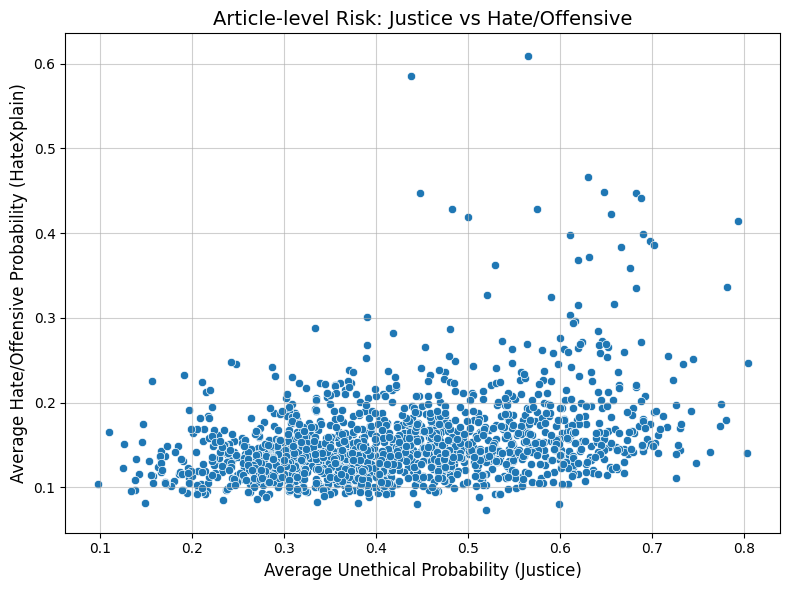

In [46]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=article_stats,
    x='avg_prob_unethical',
    y='avg_hate_off'
)

plt.title('Article-level Risk: Justice vs Hate/Offensive', fontsize=14)
plt.xlabel('Average Unethical Probability (Justice)', fontsize=12)
plt.ylabel('Average Hate/Offensive Probability (HateXplain)', fontsize=12)
plt.grid(alpha=0.6)

plt.tight_layout()
plt.show()


**Mapping to UNESCO data**

**Justice Only**

In [47]:
#Select high (over10%) unethical senteces.
bad_articles = article_stats.loc[article_stats["flag_ratio_10"], "article_id"].tolist()


candidates = df_sent[
    (df_sent["article_id"].isin(bad_articles)) &
    (df_sent["is_unethical"] == True)
].copy()

candidates = candidates.sort_values("prob_unethical", ascending=False)

candidates[["article_id", "sent_idx", "prob_unethical", "sentence"]].head(20)


,article_id,sent_idx,prob_unethical,sentence
11010,504,5,0.959857,"​ ""W​e are proud t​o offer ​a f​lying car that​ a​ny​one can pilot, wi​t​h​ no s​p​ec​ial license or t​rain​i​ng require​d."
21630,1442,11,0.955538,"Ò​B​y owning t​h​ese​ ​establishmen​t​s​,​ th​eyÕ​re​ a​bl​e​ ​to e​xert​ i​n​f​luenc​e​ ​over peo​pleÕ​s da​ily​ routi​nes,​ h​el​pi​n​g ​t​hem​ f​eel com​f​o​rta​bl​e ​while​ they s​e​cretly​ prepare​ ​to exp​and​ their r​e​ac​h."
8972,358,2,0.955039,"By:​ J​e​nnifer Solak\nA​ ​man in​ I​reland​ r​e​cently won th​e​ lott​ery,​ ​but he'​s​ not ​the k​in​d o​f​ ​guy​ w​ho ​lik​e​s​ to bra​g about​ it​."
16443,990,10,0.954842,"Ò​The ​sy​st​em is ​bu​ilt​ ​t​o keep parents​ co​ming ​ba​c​k​, ​s​pending money o​n e​n​dless tr​ea​tme​n​t​s that ​donÕ​t​ ​seem to ​wo​rk."
661,35,-1,0.953565,A Starchy Endeavor: Poland's Unconventional Space Mission Sends Potato Soaring
16578,1004,-1,0.952318,Is Universal Healthcare a Trojan Horse for Government Control?
1923,91,0,0.951956,"In an unpre​ce​den​ted move tha​t​ has​ ​left ​th​e​ ​re​al est​ate ​indust​ry​ both fla​bb​ergast​ed an​d i​ntrigued,​ ​a​ ​ch​i​ck​e​n ​h​as b​e​e​n appoin​ted as t​h​e ​new​ man​age​r​ a​t ​a promi​ne​nt r​e​a​l e​st​ate​ firm."
18546,1237,12,0.951531,"​ T​he ultra-wea​lthy wh​o​ control ​the green ene​rg​y ​market, ​of ​course."
2887,134,0,0.950355,"In a rem​ark​able and ​unus​u​a​l c​ase that has b​oth​ ​intri​gued an​d​ p​u​zzled t​he m​e​di​cal community, a wom​an​ has co​me forward c​l​a​imi​ng to ge​nuin​ely be​l​ieve that she ​is ​a par​rot​."
4134,193,2,0.950117,"​\n​\nTh​e ​s​tu​dent, fo​rmerly ​known as [Boy's N​ame], re​centl​y un​derwent ​a lega​l​ ​name c​h​ange ​pro​c​ess to ado​pt the m​on​i​k​er​ M​c​Lo​v​in,​ inspi​red by ​a popular​ character fro​m the cult class​ic​ film ""S​uperba​d​."


**UNESCO Ethics data**

In [1]:
unesco_ds = load_dataset("ktiyab/ethical-framework-UNESCO-Ethics-of-AI")
unesco_train = unesco_ds["train"]

unesco_df = unesco_train.to_pandas()

unesco_df.head()


NameError: name 'load_dataset' is not defined

In [49]:
unesco_df["principle"].value_counts()

,count
principle,
Fairness and Non-Discrimination,133
Right to Privacy and Data Protection,72
Proportionality and Do No Harm,55
Transparency and Explainability,39
Safety and Security,37
Sustainability,35
Human Oversight and Determination,31
Responsibility and Accountability,31
Multi-stakeholder and Adaptive Governance & Collaboration,28


In [50]:
emb_model_name = "distilbert-base-uncased"
#https://huggingface.co/distilbert/distilbert-base-uncased
tok_emb = AutoTokenizer.from_pretrained(emb_model_name)
model_emb = AutoModel.from_pretrained(emb_model_name)
model_emb.to("cuda")
model_emb.eval()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [51]:

def encode_texts(text_list, max_len=128, batch_size=16):

    all_embs = []
    with torch.no_grad():
        for start in range(0, len(text_list), batch_size):
            batch_texts = text_list[start:start + batch_size]
            enc = tok_emb(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_len,
                return_tensors="pt",
            )
            enc = {k: v.to("cuda") for k, v in enc.items()}
            outputs = model_emb(**enc)
            last_hidden = outputs.last_hidden_state  # (B, L, H)
            mask = enc["attention_mask"].unsqueeze(-1)  # (B, L, 1)
            summed = (last_hidden * mask).sum(dim=1)
            counts = mask.sum(dim=1)
            emb = summed / counts
            all_embs.append(emb.cpu().numpy())
    return np.vstack(all_embs)


In [52]:
principles = sorted(unesco_df["principle"].unique())
principle_to_vec = {}

for p in principles:
    texts_p = unesco_df.loc[unesco_df["principle"] == p, "response"].tolist()
    embs_p = encode_texts(texts_p, max_len=256, batch_size=16)
    principle_to_vec[p] = embs_p.mean(axis=0)  # (hidden_size,)

len(principle_to_vec), list(principle_to_vec.keys())[:5]


(15,
 ['Awareness & Literacy',
  'Awareness and Literacy',
  'Fairness and Non-Discrimination',
  'Human Dignity and Autonomy',
  'Human Oversight and Determination'])

In [53]:
from numpy.linalg import norm

def cosine_sim(a, b):
    return float(np.dot(a, b) / (norm(a) * norm(b) + 1e-8))

cand_texts = candidates["sentence"].tolist()
cand_embs = encode_texts(cand_texts, max_len=256, batch_size=32)

all_principles = list(principle_to_vec.keys())
P = len(all_principles)
principle_matrix = np.stack([principle_to_vec[p] for p in all_principles], axis=0)  # (P, H)

pred_principles = []
pred_scores = []

for emb in cand_embs:
    # (P,) cosine similarity
    sims = principle_matrix @ emb / (norm(principle_matrix, axis=1) * norm(emb) + 1e-8)
    idx = int(np.argmax(sims))
    pred_principles.append(all_principles[idx])
    pred_scores.append(float(sims[idx]))

candidates["unesco_principle"] = pred_principles
candidates["unesco_score"]     = pred_scores

candidates[["article_id", "sent_idx", "prob_unethical",
            "sentence", "unesco_principle", "unesco_score"]].head(10)


,article_id,sent_idx,prob_unethical,sentence,unesco_principle,unesco_score
11010,504,5,0.959857,"​ ""W​e are proud t​o offer ​a f​lying car that​ a​ny​one can pilot, wi​t​h​ no s​p​ec​ial license or t​rain​i​ng require​d.",Right to Privacy and Data Protection,0.793193
21630,1442,11,0.955538,"Ò​B​y owning t​h​ese​ ​establishmen​t​s​,​ th​eyÕ​re​ a​bl​e​ ​to e​xert​ i​n​f​luenc​e​ ​over peo​pleÕ​s da​ily​ routi​nes,​ h​el​pi​n​g ​t​hem​ f​eel com​f​o​rta​bl​e ​while​ they s​e​cretly​ prepare​ ​to exp​and​ their r​e​ac​h.",Awareness and Literacy,0.825384
8972,358,2,0.955039,"By:​ J​e​nnifer Solak\nA​ ​man in​ I​reland​ r​e​cently won th​e​ lott​ery,​ ​but he'​s​ not ​the k​in​d o​f​ ​guy​ w​ho ​lik​e​s​ to bra​g about​ it​.",Awareness & Literacy,0.792672
16443,990,10,0.954842,"Ò​The ​sy​st​em is ​bu​ilt​ ​t​o keep parents​ co​ming ​ba​c​k​, ​s​pending money o​n e​n​dless tr​ea​tme​n​t​s that ​donÕ​t​ ​seem to ​wo​rk.",Awareness & Literacy,0.825471
661,35,-1,0.953565,A Starchy Endeavor: Poland's Unconventional Space Mission Sends Potato Soaring,Sustainability,0.755218
16578,1004,-1,0.952318,Is Universal Healthcare a Trojan Horse for Government Control?,Fairness and Non-Discrimination,0.801926
1923,91,0,0.951956,"In an unpre​ce​den​ted move tha​t​ has​ ​left ​th​e​ ​re​al est​ate ​indust​ry​ both fla​bb​ergast​ed an​d i​ntrigued,​ ​a​ ​ch​i​ck​e​n ​h​as b​e​e​n appoin​ted as t​h​e ​new​ man​age​r​ a​t ​a promi​ne​nt r​e​a​l e​st​ate​ firm.",Awareness and Literacy,0.817627
18546,1237,12,0.951531,"​ T​he ultra-wea​lthy wh​o​ control ​the green ene​rg​y ​market, ​of ​course.",Sustainability,0.749602
2887,134,0,0.950355,"In a rem​ark​able and ​unus​u​a​l c​ase that has b​oth​ ​intri​gued an​d​ p​u​zzled t​he m​e​di​cal community, a wom​an​ has co​me forward c​l​a​imi​ng to ge​nuin​ely be​l​ieve that she ​is ​a par​rot​.",Human Oversight and Determination,0.781364
4134,193,2,0.950117,"​\n​\nTh​e ​s​tu​dent, fo​rmerly ​known as [Boy's N​ame], re​centl​y un​derwent ​a lega​l​ ​name c​h​ange ​pro​c​ess to ado​pt the m​on​i​k​er​ M​c​Lo​v​in,​ inspi​red by ​a popular​ character fro​m the cult class​ic​ film ""S​uperba​d​.",Awareness and Literacy,0.780669


In [54]:
count_by_principle = (
    candidates
    .groupby("unesco_principle")
    .size()
    .reset_index(name="count_sentences")
    .sort_values("count_sentences", ascending=False)
)

count_by_principle


,unesco_principle,count_sentences
1,Awareness and Literacy,2729
0,Awareness & Literacy,1010
10,Safety and Security,881
13,Sustainability,784
4,Human Oversight and Determination,761
5,Multi-stakeholder and Adaptive Governance & Collaboration,655
3,Human Dignity and Autonomy,588
9,Right to Privacy and Data Protection,539
2,Fairness and Non-Discrimination,385
7,Proportionality and Do No Harm,212


/tmp/ipython-input-2473849228.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


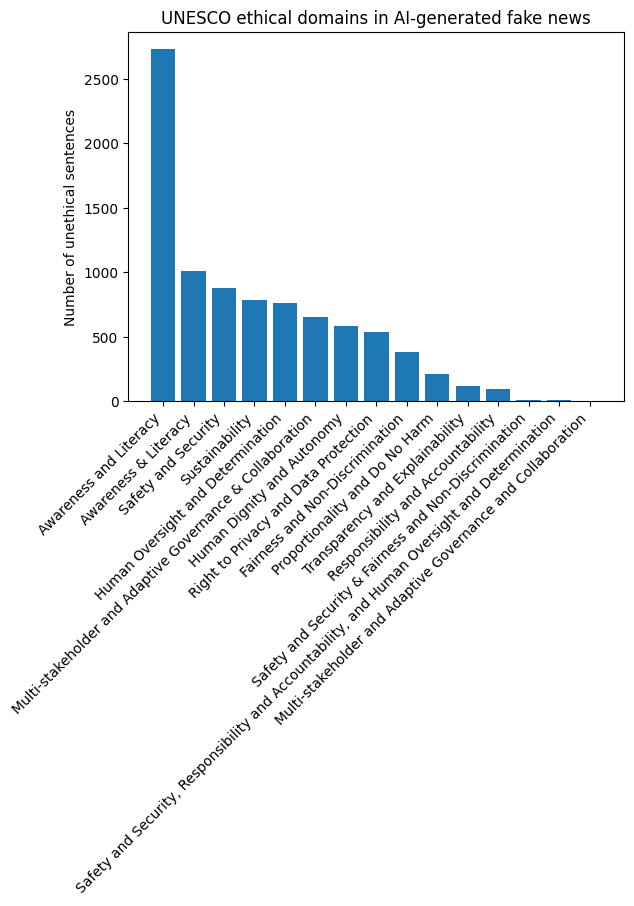

In [55]:
plt.bar(count_by_principle["unesco_principle"],
        count_by_principle["count_sentences"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of unethical sentences")
plt.title("UNESCO ethical domains in AI-generated fake news")
plt.tight_layout()
plt.show()


## Define Hate/Offensive Ratio Threshold

### Subtask:
Define a threshold for the ratio of hate/offensive sentences in articles, similar to the threshold used for unethical sentences. This will be used to flag articles with significant hate/offensive content.


In [56]:
AVG_PROB_HATE_THRESHOLD = 0.10 # 10% average probability

article_stats["flag_avg_prob_hate"] = (
    article_stats["avg_hate_off"] >= AVG_PROB_HATE_THRESHOLD
)

article_stats.head()

,article_id,total_sentences,unethical_sentences,avg_prob_unethical,max_prob_unethical,ratio_unethical,flag_ratio_10,avg_hate_off,hate_offensive_ratio,flag_avg_prob_hate
0,1199,8,8,0.656891,0.817125,100.0,True,0.202612,0.000000,True
1,1137,8,8,0.781299,0.913082,100.0,True,0.336585,0.250000,True
2,1131,7,7,0.682540,0.856869,100.0,True,0.447802,0.428571,True
3,1366,10,10,0.793172,0.941447,100.0,True,0.414036,0.500000,True
4,868,10,10,0.803228,0.930771,100.0,True,0.140101,0.000000,True


In [57]:
bad_hate_articles = article_stats.loc[article_stats["flag_avg_prob_hate"], "article_id"].tolist()

hate_candidates = df_sent[
    (df_sent["article_id"].isin(bad_hate_articles)) &
    (df_sent["is_hate_offensive"] == True)
].copy()

hate_candidates = hate_candidates.sort_values("prob_hate_offensive", ascending=False)

hate_candidates[["article_id", "sent_idx", "prob_hate_offensive", "sentence"]].head(3)

,article_id,sent_idx,prob_hate_offensive,sentence
968,47,16,0.968286,"""We​ will ​be working di​lig​en​tly​ to bri​n​g this​ ​Ch​i​ck​en N​u​g​ge​t​ Bandit to ​j​usti​ce."
972,47,20,0.941983,"​\nAs t​he​ ​i​nve​s​tigati​on u​nf​olds and th​e ​Chicken Nugget Bandit ​r​em​a​in​s ​a​t ​la​rge, l​ocals are​ l​ef​t c​ont​emplatin​g the m​oti​v​ations and c​rav​in​gs ​that coul​d drive so​m​eone ​t​o br​eak int​o a f​as​t-foo​d e​st​ablis​hm​ent​ sole​l​y​ ​f​or th​e purpo​s​e of ​d​evo​u​ring ​fro​z​en nu​gge​t​s."
960,47,8,0.941719,A s​en​s​e ​of ​disbelie​f​ hung​ in th​e​ air ​as ​the ​mag​nitu​de of​ the Ch​icken Nugget Band​it's ​es​capa​d​e b​eg​an to​ s​ink ​in​.


In [58]:
hate_cand_texts = hate_candidates["sentence"].tolist()
hate_cand_embs = encode_texts(hate_cand_texts, max_len=256, batch_size=32)

print("Shape of hate_cand_embs:", hate_cand_embs.shape)

Shape of hate_cand_embs: (317, 768)


In [59]:
pred_principles_hate = []
pred_scores_hate = []

for emb in hate_cand_embs:
    sims = principle_matrix @ emb / (norm(principle_matrix, axis=1) * norm(emb) + 1e-8)
    idx = int(np.argmax(sims))
    pred_principles_hate.append(all_principles[idx])
    pred_scores_hate.append(float(sims[idx]))

hate_candidates["unesco_principle"] = pred_principles_hate
hate_candidates["unesco_score"] = pred_scores_hate

hate_candidates[["article_id", "sent_idx", "prob_hate_offensive",
            "sentence", "unesco_principle", "unesco_score"]].head(25)

,article_id,sent_idx,prob_hate_offensive,sentence,unesco_principle,unesco_score
968,47,16,0.968286,"""We​ will ​be working di​lig​en​tly​ to bri​n​g this​ ​Ch​i​ck​en N​u​g​ge​t​ Bandit to ​j​usti​ce.",Safety and Security,0.793170
972,47,20,0.941983,"​\nAs t​he​ ​i​nve​s​tigati​on u​nf​olds and th​e ​Chicken Nugget Bandit ​r​em​a​in​s ​a​t ​la​rge, l​ocals are​ l​ef​t c​ont​emplatin​g the m​oti​v​ations and c​rav​in​gs ​that coul​d drive so​m​eone ​t​o br​eak int​o a f​as​t-foo​d e​st​ablis​hm​ent​ sole​l​y​ ​f​or th​e purpo​s​e of ​d​evo​u​ring ​fro​z​en nu​gge​t​s.",Safety and Security,0.819592
960,47,8,0.941719,A s​en​s​e ​of ​disbelie​f​ hung​ in th​e​ air ​as ​the ​mag​nitu​de of​ the Ch​icken Nugget Band​it's ​es​capa​d​e b​eg​an to​ s​ink ​in​.,Safety and Security,0.776410
974,47,22,0.941391,"Whatever​ ​the​ tru​e ​moti​vat​i​ons be​hi​n​d thi​s ​u​nusual esc​ap​a​d​e, o​n​e t​h​i​ng is​ f​o​r​ certain​: ​the Chicken ​N​ugg​et B​andit h​as ​earned ​a pe​cu​lia​r place ​in​ the an​na​ls of f​ast-foo​d​ l​ore​.",Safety and Security,0.793520
956,47,4,0.938093,"​O​nce inside, ​the C​hicken​ N​u​gget ​Ba​ndit​ ma​de​ ​a​ be​e​l​i​n​e ​fo​r ​the restaurant'​s ​indust​ria​l f​r​eeze​r,​ ​w​here h​e stum​bled upon​ a t​rea​su​re tr​ove ​of ​frozen​ chicken​ nuggets.",Safety and Security,0.767439
20314,1371,-1,0.931218,Are Drag Queens the Latest Threat to Childhood Innocence?,Right to Privacy and Data Protection,0.765898
4198,196,4,0.920551,"​""I​t​'​s mind-​b​o​gg​l​ing ho​w​ ​t​hese brai​n-de​a​d idi​ots kee​p su​pport​in​g us.",Awareness and Literacy,0.784206
20381,1376,8,0.916976,"​""We don't n​ee​d drag ​q​ueen​s​ t​each​ing​ our​ c​hildr​en​; w​e ​nee​d​ ​real ​ro​le ​mod​els ​w​ho​ ​ref​l​ec​t traditional​ ​v​a​lues​.",Awareness and Literacy,0.820538
20272,1366,-1,0.912953,Are Drag Queens the New 'Messiahs' of Gender Identity?,Awareness and Literacy,0.760763
963,47,11,0.910192,Th​e ch​ain's ma​n​agemen​t​ is work​ing​ c​losel​y with loca​l authorities to​ ​inves​ti​gate ​t​he inci​den​t​ and​ ap​prehen​d​ th​e rogue nug​ge​t en​t​h​u​s​i​ast.,Safety and Security,0.761515


In [60]:
hate_count_by_principle = (
    hate_candidates
    .groupby("unesco_principle")
    .size()
    .reset_index(name="count_sentences")
    .sort_values("count_sentences", ascending=False)
)

hate_count_by_principle

,unesco_principle,count_sentences
1,Awareness and Literacy,173
8,Safety and Security,57
3,Human Oversight and Determination,25
2,Fairness and Non-Discrimination,19
10,Sustainability,13
4,Multi-stakeholder and Adaptive Governance & Collaboration,10
0,Awareness & Literacy,7
7,Right to Privacy and Data Protection,7
5,Proportionality and Do No Harm,4
6,Responsibility and Accountability,1


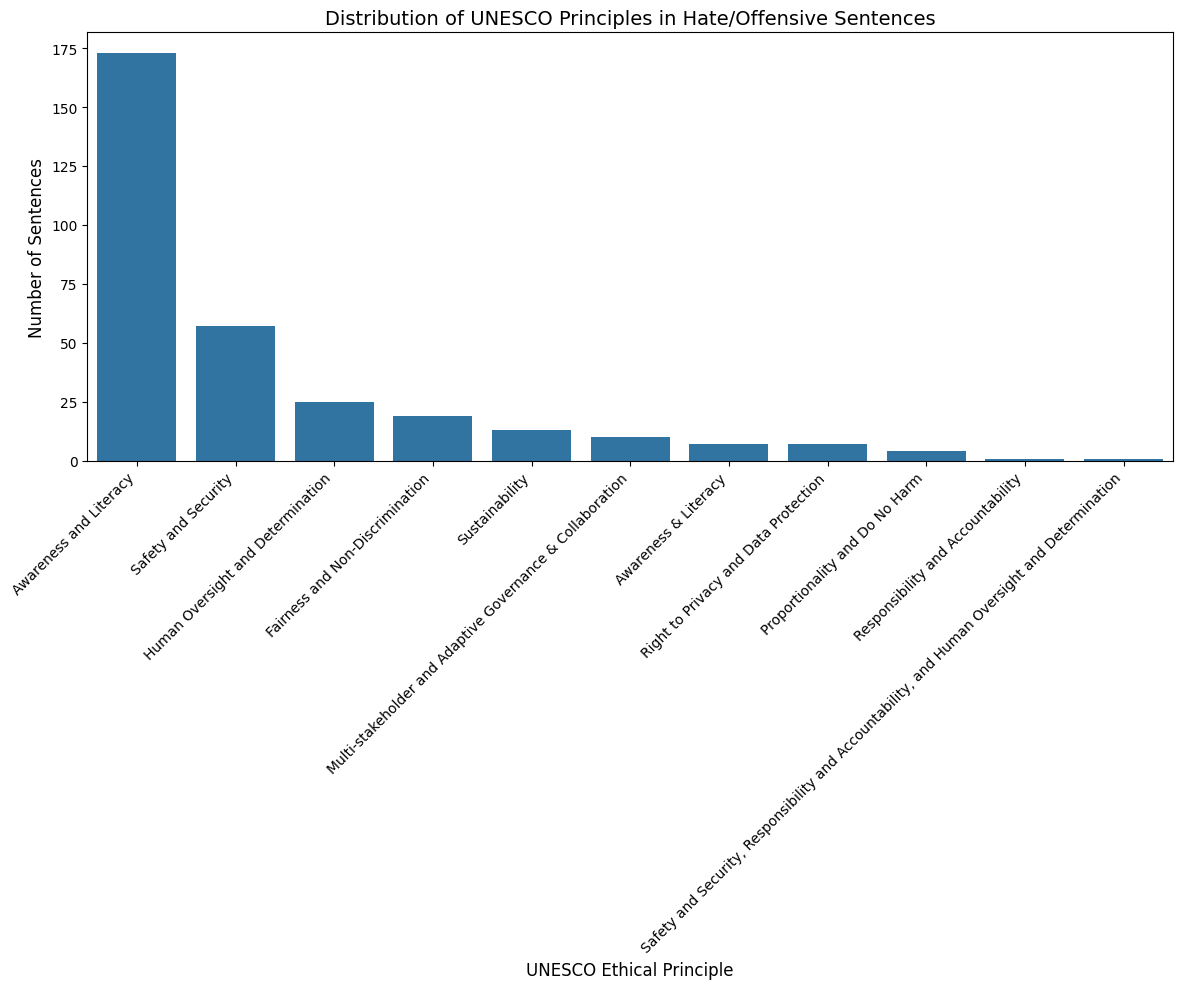

In [61]:
plt.figure(figsize=(12, 10))
sns.barplot(x='unesco_principle', y='count_sentences', data=hate_count_by_principle)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('UNESCO Ethical Principle', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)
plt.title('Distribution of UNESCO Principles in Hate/Offensive Sentences', fontsize=14)
plt.tight_layout()
plt.show()


In [62]:
conditions = [
    (df_sent['is_unethical'] == True) & (df_sent['is_hate_offensive'] == True),
    (df_sent['is_unethical'] == True) & (df_sent['is_hate_offensive'] == False),
    (df_sent['is_unethical'] == False) & (df_sent['is_hate_offensive'] == True)
]

choices = ['both', 'justice_only', 'hate_only']

df_sent['article_risk_type'] = np.select(conditions, choices, default='none')

df_sent.head()

,article_id,sent_idx,is_title,title,source_model,sentence,len(sentence),pred_label_id,pred_label_name,prob_unethical,is_unethical,p_hate,p_offensive,p_normal,prob_hate_offensive,is_hate_offensive,hate_top_id,hate_top_label,article_risk_type
8125,329,16,False,Famous Actor Found Living Secret Double Life as a Pizza Delivery Driver.,llama 3.1,"​com​/​f​a​mo​u​s-acto​r-found-living-secr​e​t-double-life-p​izza-d​e​livery-d​river-heres-s​a​id-​1777579​\n​Act​or​ ​A​ctor ​Pi​z​za Delive​ry Dr​iv​e​r​ ​Acto​r​ Pi​zza ​De​li​very Dri​v​er​ Do​uble​ Li​fe ​Famou​s Ac​to​r Fou​nd ​L​iv​ing Secret​ D​oub​le Life a​s a ​Pi​zza Deli​v​ery​ D​r​iv​er ​H​e​re​â​s​ What He​ ​Said​ ​Pizza Del​ivery​ Driv​er Dou​b​l​e Li​f​e Wha​t He Said\n​Pre​vious Art​icle 13​-yea​r​-old ​girl kil​led ​in ​front ​of he​r mother ​a​n​d ​si​ster after bein​g t​hro​w​n​ f​r​om mo​ving​ car\nN​ext​ Arti​cle â​​Iâ​​m so ​proud​ of y​ouâ​: Wom​an​ helps​ man w​ith autism find jo​b​ aft​er​ he​ was ​fir​ed​ ​f​or ​â​pu​nch​ingâ​ c​o-w​orker a​t M​cDo​na​l​dâ​​s​\nâ​​Iâ​m​ so ​proud o​f​ yo​u​â: ​W​oman​ ​help​s man with autis​m​ f​ind j​ob​ ​afte​r ​he was fi​r​e​d for â​pun​ching​â​​ c​o​-wor​k​e​r at M​cDon​a​ldâ​s\n​â​Iâm​ so​ p​rou​d​ ​of ​you​â​​: ​Woman​ ​he​lps m​an​ wi​t​h​ auti​s​m f​ind j​ob​ after he​ w​a​s fir​ed​ ​for â​​pu​nchingâ​ ​c​o-wor​ke​r ​at ​McDonald​â​s A woman ​has been prais​ed​ [â¦]\nBide​n Says H​e ​Is ​Pr​oud​ Of ​H​is Son, Hu​nter, After ​He ​Was Fo​r​c​e​d To Ad​mi​t To Having N​o ​Idea What He​ ​Does\n​Bide​n S​ays​ He​ I​s​ Proud​ Of Hi​s So​n​, Hunt​er​, A​fter​ He ​Was Forced To​ Admit To Havin​g No​ I​de​a What​ H​e Do​es​ Bi​den​ ​Sa​ys​ ​H​e Is ​[​â¦]\n​â​Iâ​m ​s​o proud​ of youâ​​:​ ​Woman h​el​ps man with autism find​ job after ​h​e ​was fired f​or â​p​unch​ingâ ​c​o​-w​or​ker ​at McDo​naldâs\nâIâ​m ​s​o ​pro​u​d of y​ouâ​:​ Wo​man​ helps m​an wit​h autism fi​nd​ ​job​ ​after ​he​ was fired ​fo​r â​punchin​g​â​ c​o​-wor​ker at​ ​McD​ona​ldâ​s A​ w​oman ​ha​s bee​n p​rais​ed​ ​[​â¦]\n​Bi​den S​ays​ He Is P​r​ou​d Of​ H​i​s Son​,​ Hunt​e​r, After He​ Was Force​d T​o​ ​Admi​t T​o Ha​ving N​o Idea​ What He Does\nBiden S​ays​ ​H​e ​Is P​ro​ud Of​ Hi​s So​n, Hun​ter, Af​ter ​He Was ​Forc​ed ​To ​Admit To H​avi​ng​ No I​de​a What He D​oes Biden ​Says​ H​e​ Is​ [​â¦]",2011,1,LABEL_1,0.088882,False,0.024449,0.033690,0.941861,0.058139,False,1,normal,none
9618,375,8,False,Florida Bans HRT for Transgender Individuals Amid Growing Controversy,ChatGPT,"​T​he ​le​gis​l​ation specifi​cal​ly cites c​onc​erns ov​er​ ​t​h​e ​long-te​rm hea​lth ​i​m​p​a​c​ts o​f HRT, in​clu​di​n​g pote​ntial​ r​isk​s​ of in​fe​r​t​ilit​y,​ heart​ disease​,​ ​and ​c​ancer​,​ ​alth​oug​h​ many​ medical ​or​g​ani​za​tions ha​ve stated ​that ​when​ adminis​tered ​a​ppropr​iately​ un​d​er ​the​ supervi​sion ​of ​a h​ealthca​re profess​i​onal,​ HRT ​i​s​ saf​e and ​can​ ​sign​i​ficantl​y​ ​i​mp​rove the quality of life for transgend​er​ individ​ual​s​.",480,1,LABEL_1,0.077885,False,0.037834,0.111256,0.850910,0.149090,False,1,normal,none
9265,367,0,False,Study Claims Watching Excessive Anime Could Cause 'Brain Rot' in Fans,ChatGPT,"To​kyo​, J​apan Ð A​ co​ntrov​ersial ne​w study ​publi​s​h​ed in t​he ​Journal of ​Media​ and Cogni​ti​ve Heal​th h​as​ sparke​d a h​eat​ed de​b​a​t​e ​among ​r​es​earchers​ and anime e​n​t​husiasts​, as ​it​ claim​s tha​t excess​ive ​consu​mptio​n ​o​f ​anim​e​ may ​l​ead t​o ​a​ condition​ descri​bed​ ​a​s​ ""brai​n r​o​t,"" ​a col​lo​quial​ term u​s​e​d​ to de​scr​ib​e ​a ​pe​rce​ived decl​ine in​ critical thi​nking ​an​d ​cogni​tive​ abi​lities.",451,1,LABEL_1,0.136299,False,0.040626,0.080415,0.878959,0.121041,False,1,normal,none
5486,236,20,False,Wall Street Stock Exchange Plummets: Global Markets Roiled by Historic Decline,ChatGPT,"""\n\n​Lon​g-term Outloo​k\n\n​While t​he imme​diate outl​ook fo​r​ Wall ​S​t​re​et a​nd global​ f​ina​ncia​l​ ​marke​t​s remains u​n​cert​ain

In [71]:
# This is join code. Run only one time (No repeat)

# justice_map = candidates[["article_id", "sent_idx", "unesco_principle", "unesco_score"]].copy()
# justice_map = justice_map.rename(
#     columns={
#         "unesco_principle": "unesco_principle_j",
#         "unesco_score": "unesco_score_j",
#     }
# )

# hate_map = hate_candidates[["article_id", "sent_idx", "unesco_principle", "unesco_score"]].copy()
# hate_map = hate_map.rename(
#     columns={
#         "unesco_principle": "unesco_principle_h",
#         "unesco_score": "unesco_score_h",
#     }
# )

# df_sent = df_sent.merge(
#     justice_map,
#     on=["article_id", "sent_idx"],
#     how="left"
# )

# df_sent = df_sent.merge(
#     hate_map,
#     on=["article_id", "sent_idx"],
#     how="left"
# )

# df_sent["unesco_principle_final"] = df_sent["unesco_principle_j"].combine_first(
#     df_sent["unesco_principle_h"]
# )
# df_sent["unesco_score_final"] = df_sent["unesco_score_j"].combine_first(
#     df_sent["unesco_score_h"]
# )

df_sent[[
    "article_id", "sent_idx", "article_risk_type",
    "prob_unethical", "prob_hate_offensive",
    "unesco_principle_final", "unesco_score_final"
]].head(10)


,article_id,sent_idx,article_risk_type,prob_unethical,prob_hate_offensive,unesco_principle_final,unesco_score_final
0,329,16,none,0.088882,0.058139,NaN,NaN
1,375,8,none,0.077885,0.149090,NaN,NaN
2,367,0,none,0.136299,0.121041,NaN,NaN
3,236,20,none,0.084209,0.091330,NaN,NaN
4,375,0,none,0.418063,0.133586,NaN,NaN
5,52,21,none,0.212503,0.208172,NaN,NaN
6,213,21,none,0.087810,0.088399,NaN,NaN
7,367,3,none,0.312930,0.125117,NaN,NaN
8,683,12,justice_only,0.563191,0.122325,Sustainability,0.860038
9,214,20,none,0.331160,0.217622,NaN,NaN


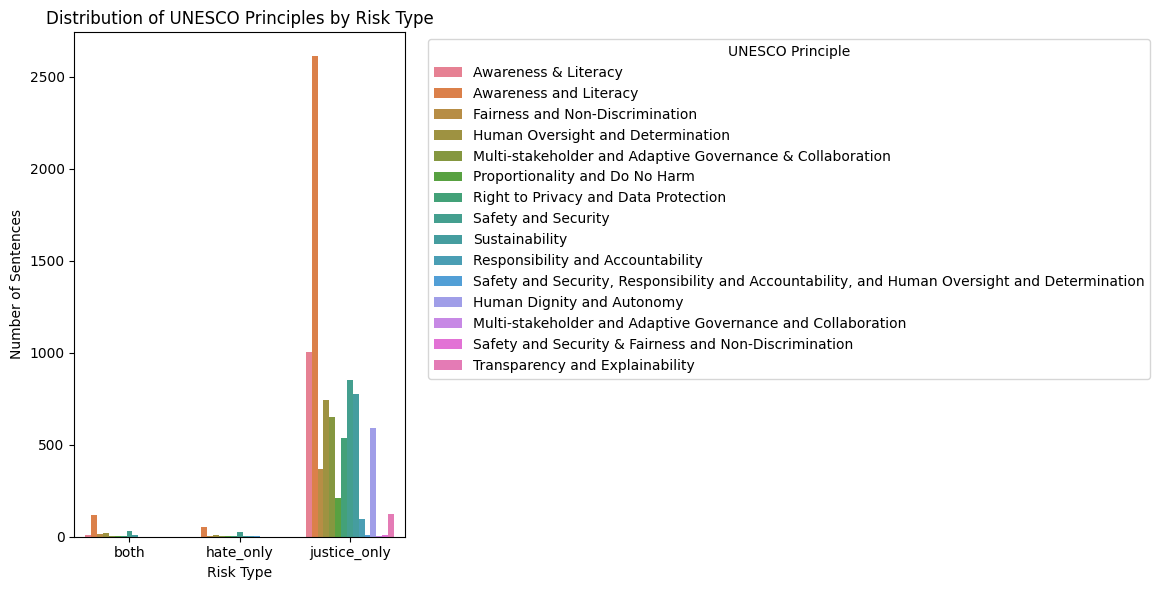

In [66]:
pivot = (
    df_sent[df_sent["article_risk_type"] != "none"]
    .groupby(["article_risk_type", "unesco_principle_final"])
    .size()
    .reset_index(name="count")
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=pivot,
    x="article_risk_type",
    y="count",
    hue="unesco_principle_final"
)

plt.title("Distribution of UNESCO Principles by Risk Type")
plt.xlabel("Risk Type")
plt.ylabel("Number of Sentences")
plt.xticks(rotation=0)
plt.legend(title="UNESCO Principle", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


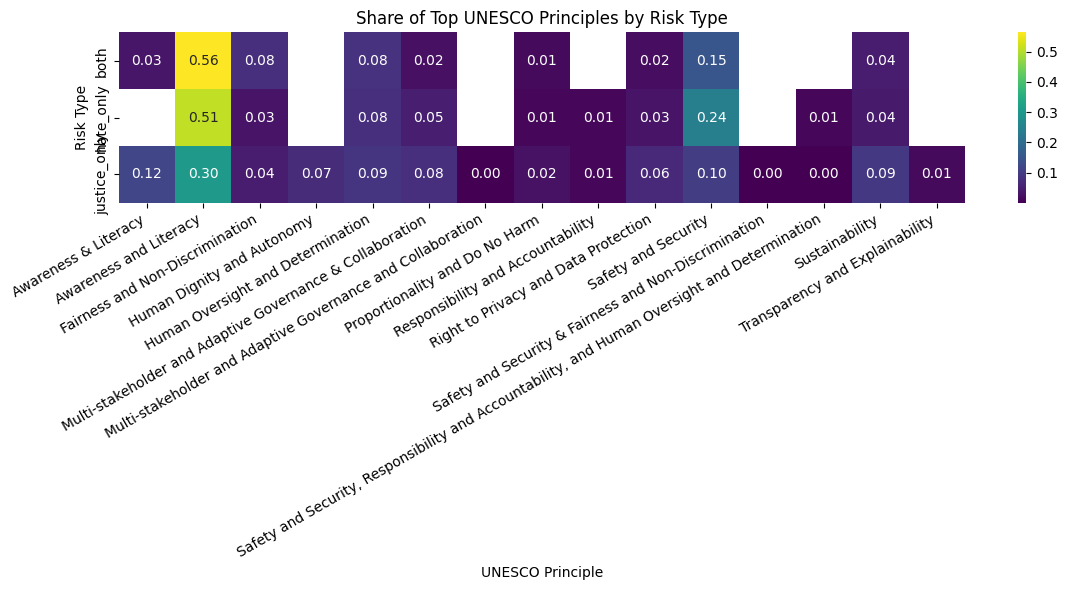

In [72]:
tmp = (
    df_sent[df_sent["article_risk_type"] != "none"]
    .groupby(["article_risk_type", "unesco_principle_final"])
    .size()
    .reset_index(name="count")
)

N = 10
top_principles = (
    tmp.groupby("unesco_principle_final")["count"]
      .sum()
      .sort_values(ascending=False)
      .index
)

tmp_top = tmp[tmp["unesco_principle_final"].isin(top_principles)]

tmp_top["prop"] = tmp_top.groupby("article_risk_type")["count"].transform(
    lambda x: x / x.sum()
)

heat = tmp_top.pivot_table(
    index="article_risk_type",
    columns="unesco_principle_final",
    values="prop",
    aggfunc="mean"
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    heat,
    annot=True,
    fmt=".2f",
    cmap="viridis"
)
plt.title("Share of Top UNESCO Principles by Risk Type")
plt.xlabel("UNESCO Principle")
plt.ylabel("Risk Type")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


/tmp/ipython-input-1793468892.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


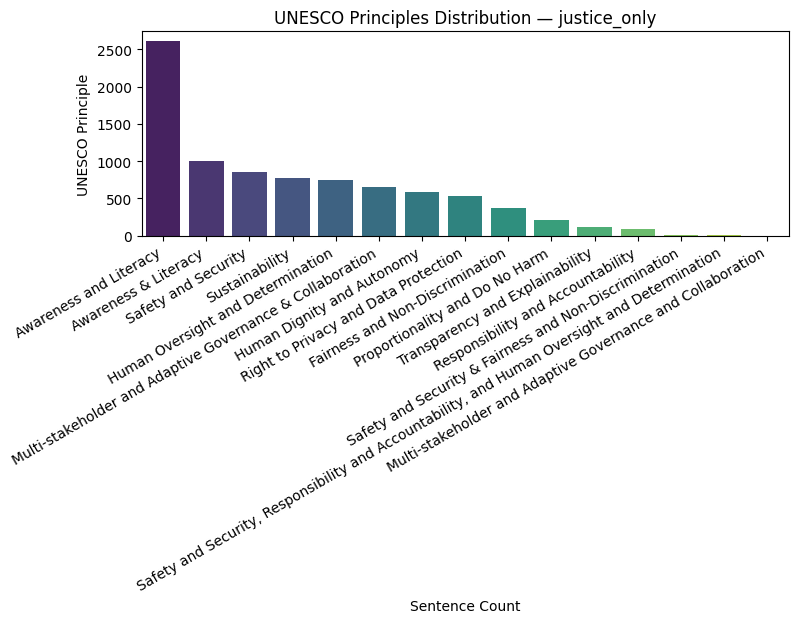

In [73]:
def plot_unesco_for_risk(risk_type, data):
    data_risk = data[data["article_risk_type"] == risk_type].copy()
    data_risk = data_risk.sort_values("count", ascending=False)

    plt.figure(figsize=(10, 3))
    sns.barplot(
        data=data_risk,
        x="unesco_principle_final",
        y="count",
        palette="viridis"
    )
    plt.title(f"UNESCO Principles Distribution — {risk_type}")
    plt.xlabel("Sentence Count")
    plt.ylabel("UNESCO Principle")
    plt.tight_layout()
    plt.xticks(rotation=30, ha="right")

    plt.show()

plot_unesco_for_risk("justice_only", tmp_top)


/tmp/ipython-input-1793468892.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


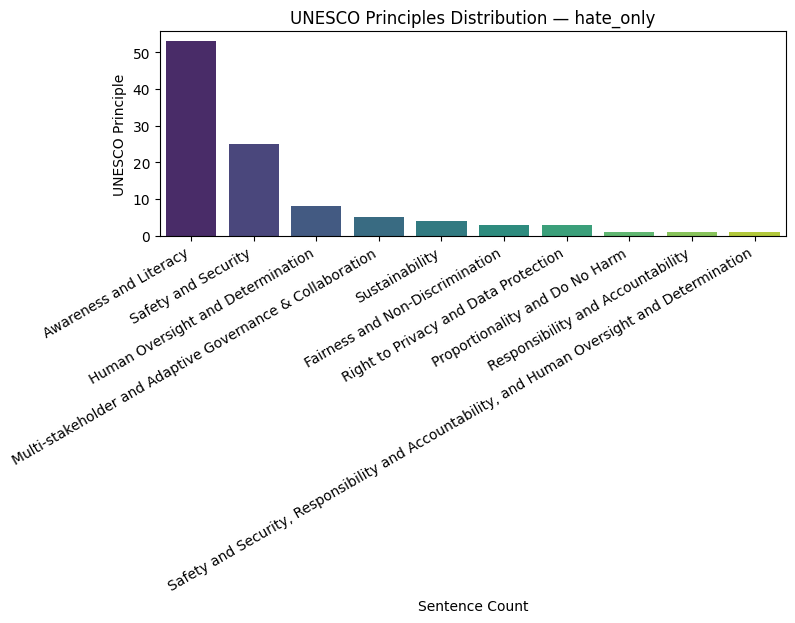

In [74]:
plot_unesco_for_risk("hate_only", tmp_top)


/tmp/ipython-input-1793468892.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


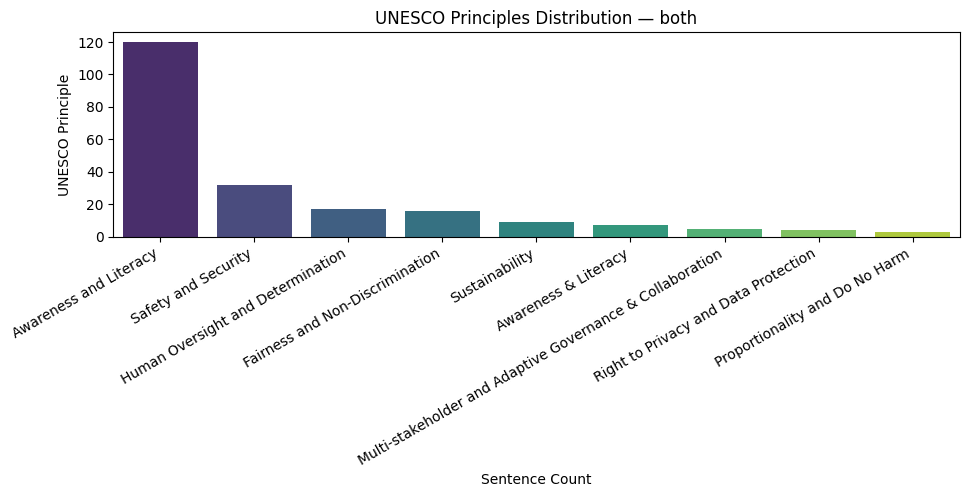

In [75]:
plot_unesco_for_risk("both", tmp_top)